In [1]:
!pip install pandas matplotlib seaborn scipy numpy


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import os   
import math

In [3]:

sns.set(style="whitegrid", context="talk")

csv_path = "/home/aureliaaa/Downloads/PAAD/PAAD/date/dataset_lunar_energie.csv"

# load, parse dates, coerce numerics
df = pd.read_csv(csv_path, parse_dates=["date"], dayfirst=True)
df = df.sort_values("date").reset_index(drop=True)
# keep a datetime index for time-series plots
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.set_index("date")

# coerce all other columns to numeric where possible (NA -> NaN)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

In [4]:
# Define numeric columns (exclude date, year, month, and uninformative columns)
numeric_cols = [c for c in df.select_dtypes(include="number").columns 
                if c not in ("year", "month", "variatio_stocurilor", "rotor_area_m2")]
print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}\n")

Numeric columns (16): ['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT', 'PRECTOTCORR_SUM', 'PS', 'RH2M', 'T2M', 'WS50M', 'producere', 'import', 'procurat_din_alte_surse', 'variatia_stocurilor', 'export', 'consum_final_brut', 'consum_sector_rezidential', 'pv_energy_kwh_day', 'wind_energy_kwh_day']



In [4]:


summary_df = df.describe(include="all").T
dtypes = df.dtypes.rename("dtype")
missing = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2),
    "n_unique": df.nunique(dropna=False)
})
meta = pd.concat([dtypes, missing, summary_df[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]], axis=1)
display(meta)

# Outlier detection for numeric columns
numeric_cols = df.select_dtypes(include="number").columns.tolist()
outlier_stats = []
for c in numeric_cols:
    s = df[c].dropna()
    if s.empty:
        outlier_stats.append((c, np.nan, np.nan, np.nan, np.nan))
        continue
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    # IQR rule bounds
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    iqr_outliers = s[(s < lower) | (s > upper)].shape[0]
    # z-score method (>3 or <-3)
    z = np.abs(stats.zscore(s))
    z_outliers = np.sum(z > 3)
    outlier_stats.append((c, int(s.size), iqr_outliers, z_outliers, f"{lower:.4g},{upper:.4g}"))

outlier_df = pd.DataFrame(outlier_stats, columns=["column", "n_obs", "iqr_outliers", "z_outliers", "iqr_bounds"])
display(outlier_df.set_index("column"))

dtype  missing_count  missing_pct  n_unique  \
ALLSKY_SFC_SW_DWN          float64              6         4.55       126   
CLOUD_AMT                  float64              6         4.55       126   
PRECTOTCORR_SUM            float64              3         2.27       129   
PS                         float64              3         2.27        87   
RH2M                       float64              3         2.27       129   
T2M                        float64              3         2.27       127   
WS50M                      float64              3         2.27       106   
producere                  float64              3         2.27       130   
import                     float64              3         2.27       123   
procurat_din_alte_surse    float64              3         2.27       119   
variatia_stocurilor        float64              3         2.27         2   
export                     float64              3         2.27        66   
consum_final_brut          float64              3         2.27       130   
consum_sector_rezidential  float64              3         2.27       130   
pv_energy_kwh_day          float64              6         4.55       126   
rotor_area_m2              float64              0         0.00         1   
wind_energy_kwh_day        float64              3         2.27       106   

                           count           mean           std            min  \
ALLSKY_SFC_SW_DWN          126.0       3.624288      2.041426       0.613400   
CLOUD_AMT                  126.0      61.732778     15.500695      21.730000   
PRECTOTCORR_SUM            129.0      46.643023     31.741676       4.310000   
PS                         129.0      99.988062      0.375061      99.180000   
RH2M                       129.0      71.853101     13.619834      44.110000   
T2M                        129.0      11.119845      9.517314      -6.940000   
WS50M                      129.0       5.682171      0.740781       4.010000   
producere                  129.0   78745.541085  56550.343183    3848.600000   
import                     129.0   60441.617829  77068.847612       0.000000   
procurat_din_alte_surse    129.0  232024.981395  82913.609878       0.000000   
variatia_stocurilor        129.0       0.000000      0.000000       0.000000   
export                     129.0   10014.120155  17194.420101       0.000000   
consum_final_brut          129.0  361198.023256  49889.046880  254467.400000   
consum_sector_rezidential  129.0  142374.351163  14617.558669  114167.000000   
pv_energy_kwh_day          126.0      11.090322      6.246763       1.877004   
rotor_area_m2              132.0    5026.548246      0.000000    5026.548246   
wind_energy_kwh_day        129.0    5700.488023   2271.675249    1905.813062   

                                     25%            50%            75%  \
ALLSKY_SFC_SW_DWN               1.691325       3.388650       5.632650   
CLOUD_AMT                      50.525000      61.225000      75.177500   
PRECTOTCORR_SUM                23.820000      37.970000      61.230000   
PS                             99.730000      99.930000     100.180000   
RH2M                           60.600000      71.940000      83.570000   
T2M                             2.210000      10.870000      20.430000   
WS50M                           5.120000       5.640000       6.190000   
producere                   27714.700000   59937.900000  131214.900000   
import                        961.300000   41705.100000   83688.600000   
procurat_din_alte_surse    222689.400000  250198.200000  276439.000000   
variatia_stocurilor             0.000000       0.000000       0.000000   
export                          7.100000       8.100000   17539.200000   
consum_final_brut          328344.700000  355599.100000  389111.700000   
consum_sector_rezidential  132023.000000  139783.100000  150033.000000   
pv_energy_kwh_day               5.175454      10.369269      17.235909   
rotor_area_m2                5026.5

/tmp/ipykernel_35767/3152569826.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = np.abs(stats.zscore(s))


n_obs  iqr_outliers  z_outliers  \
column                                                       
ALLSKY_SFC_SW_DWN            126             0           0   
CLOUD_AMT                    126             0           0   
PRECTOTCORR_SUM              129             8           0   
PS                           129             4           2   
RH2M                         129             0           0   
T2M                          129             0           0   
WS50M                        129             1           1   
producere                    129             0           1   
import                       129            12           1   
procurat_din_alte_surse      129            12           0   
variatia_stocurilor          129             0           0   
export                       129             7           2   
consum_final_brut            129             3           3   
consum_sector_rezidential    129             3           1   
pv_energy_kwh_day            126             0           0   
rotor_area_m2                132             0           0   
wind_energy_kwh_day          129             1           1   

                                     iqr_bounds  
column                                           
ALLSKY_SFC_SW_DWN                  -4.221,11.54  
CLOUD_AMT                           13.55,112.2  
PRECTOTCORR_SUM                    -32.29,117.3  
PS                                  99.06,100.9  
RH2M                                  26.15,118  
T2M                                -25.12,47.76  
WS50M                               3.515,7.795  
producere                  -1.275e+05,2.865e+05  
import                     -1.231e+05,2.078e+05  
procurat_din_alte_surse     1.421e+05,3.571e+05  
variatia_stocurilor                         0,0  
export                     -2.629e+04,4.384e+04  
consum_final_brut           2.372e+05,4.803e+05  
consum_sector_rezidential     1.05e+05,1.77e+05  
pv_energy_kwh_day                  -12.92,35.33  
rotor_area_m2                         5027,5027  
wind_energy_kwh_day            -597.6,1.157e+04

Numeric columns (16): ['ALLSKY_SFC_SW_DWN', 'CLOUD_AMT', 'PRECTOTCORR_SUM', 'PS', 'RH2M', 'T2M', 'WS50M', 'producere', 'import', 'procurat_din_alte_surse', 'export', 'consum_final_brut', 'consum_sector_rezidential', 'pv_energy_kwh_day', 'rotor_area_m2', 'wind_energy_kwh_day']



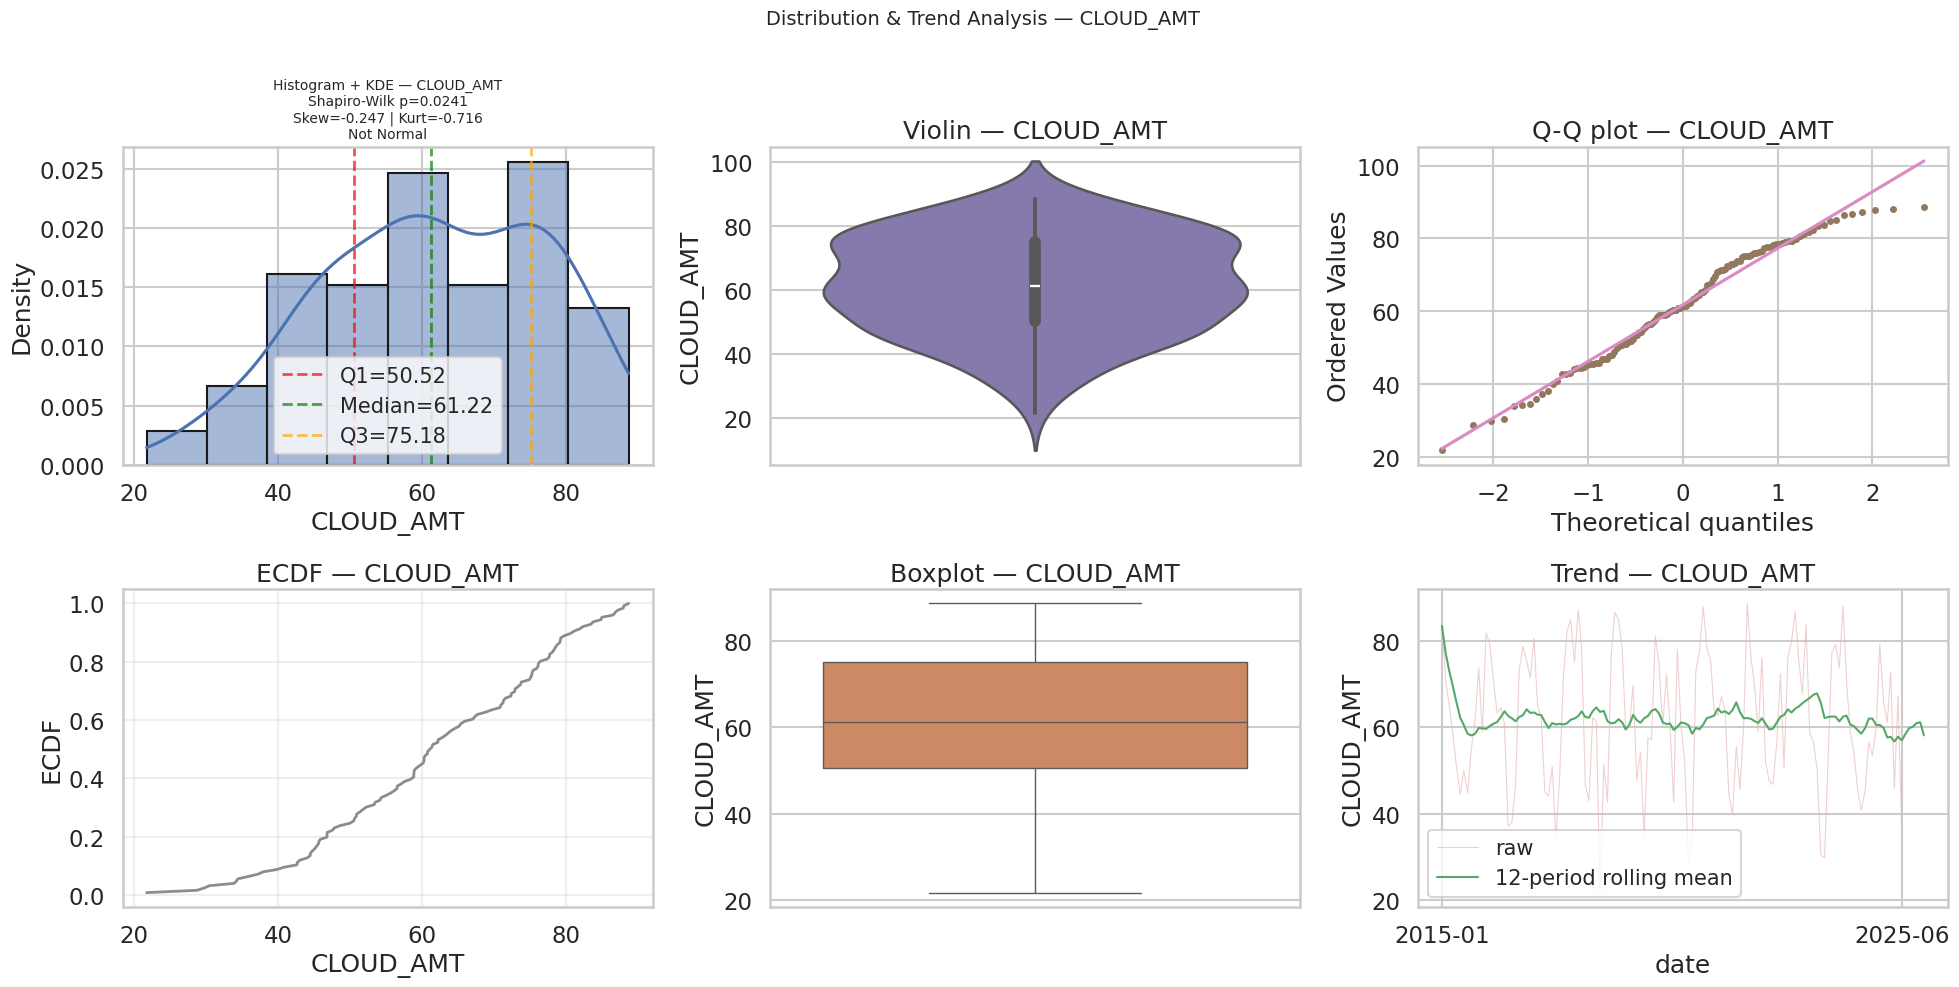

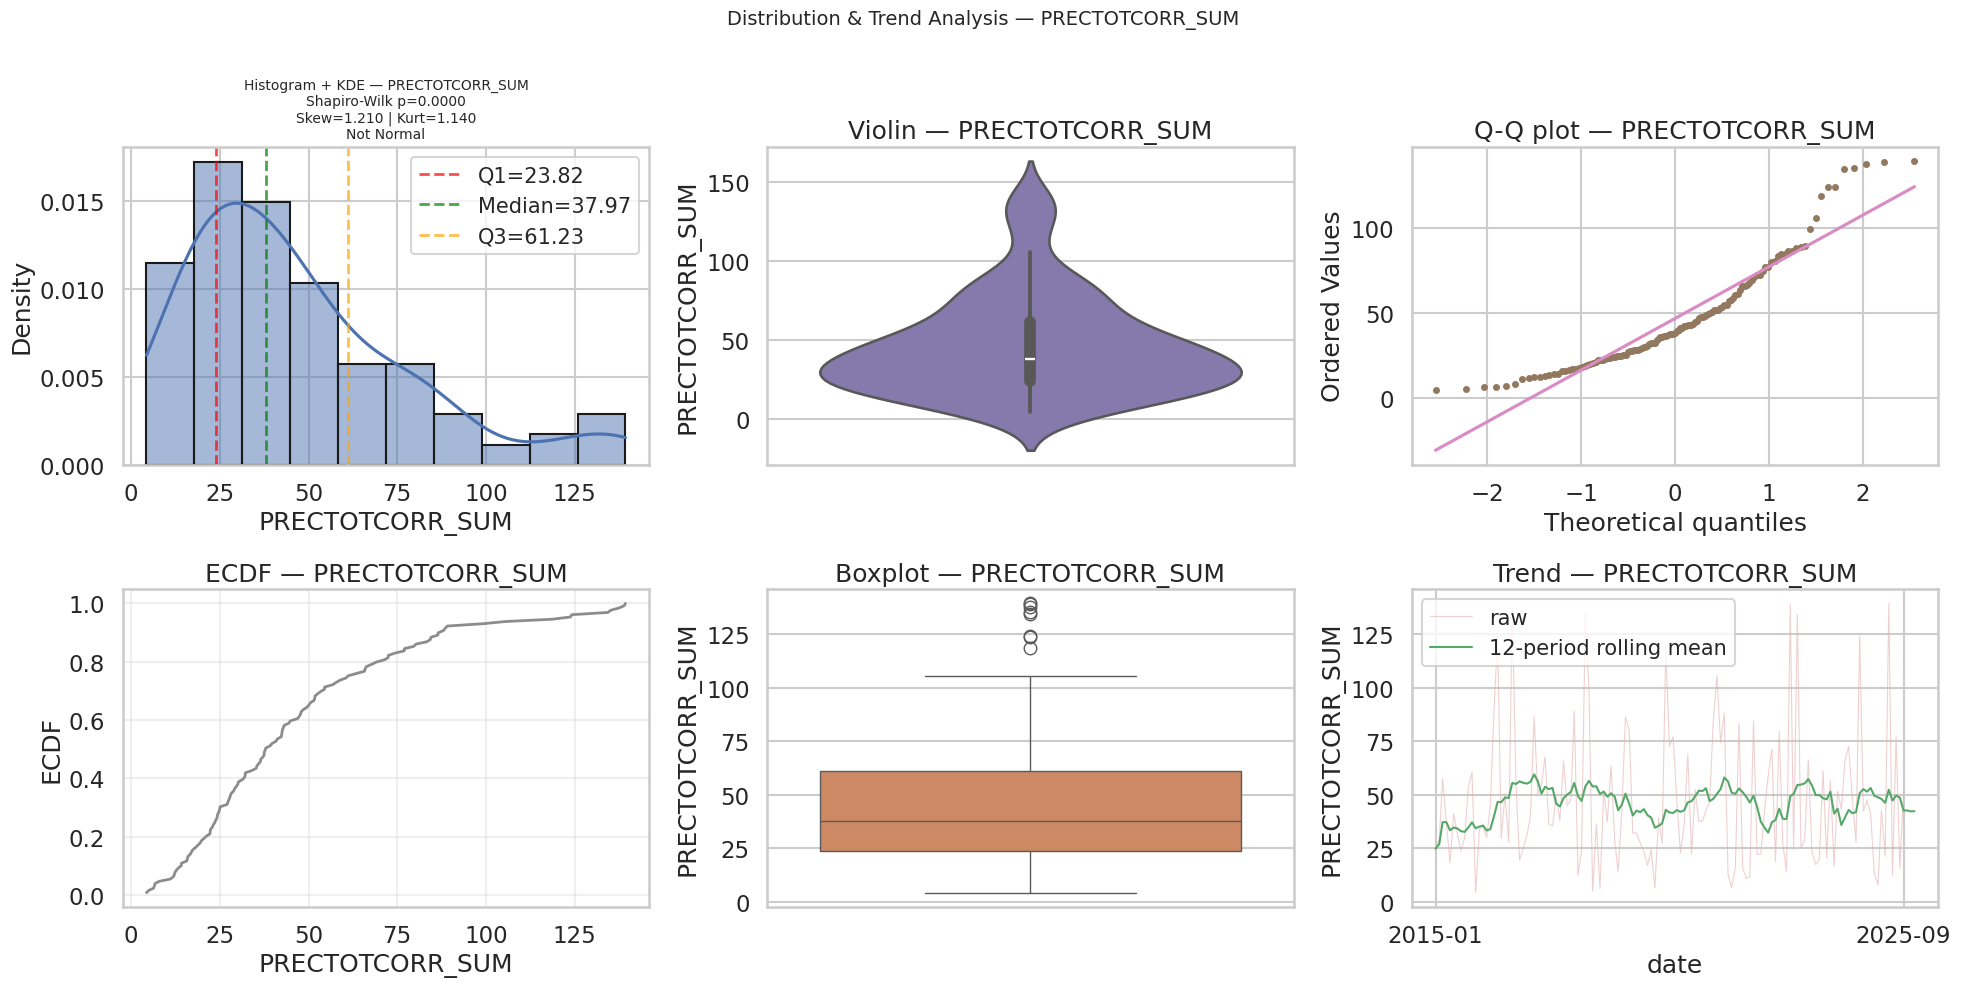

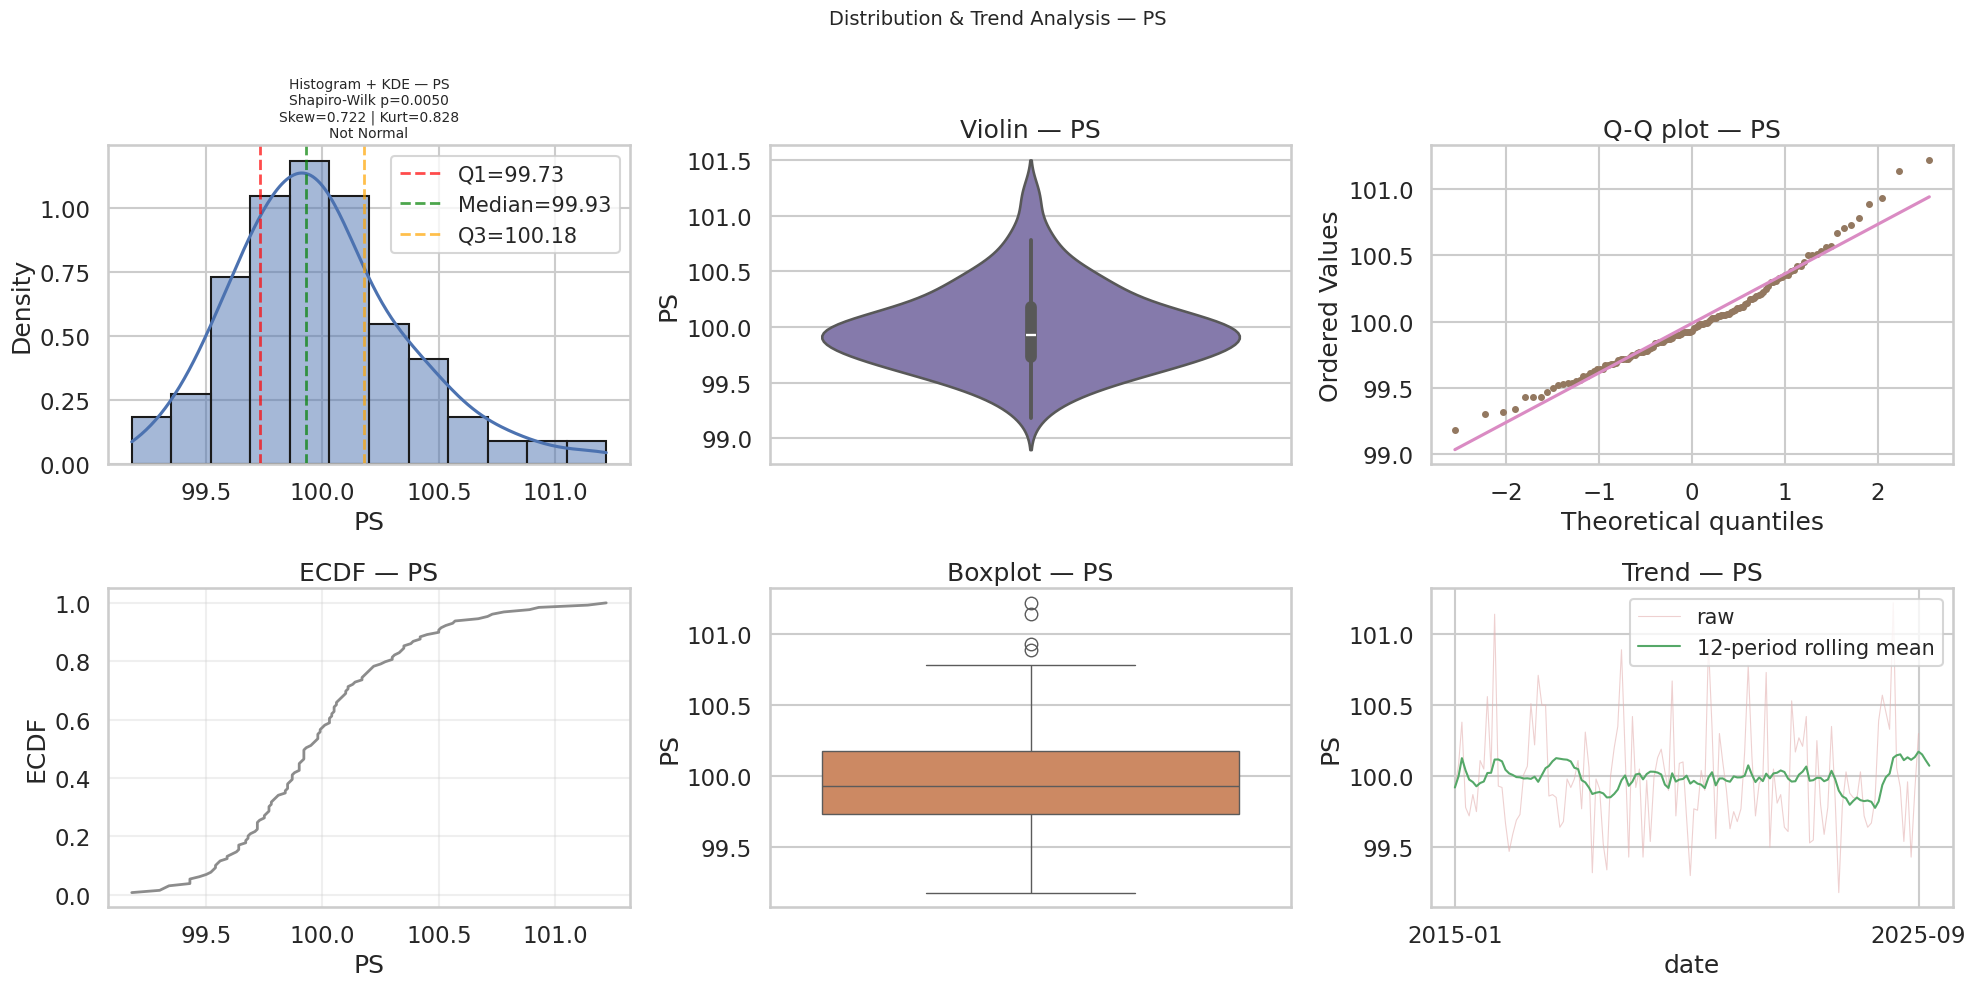

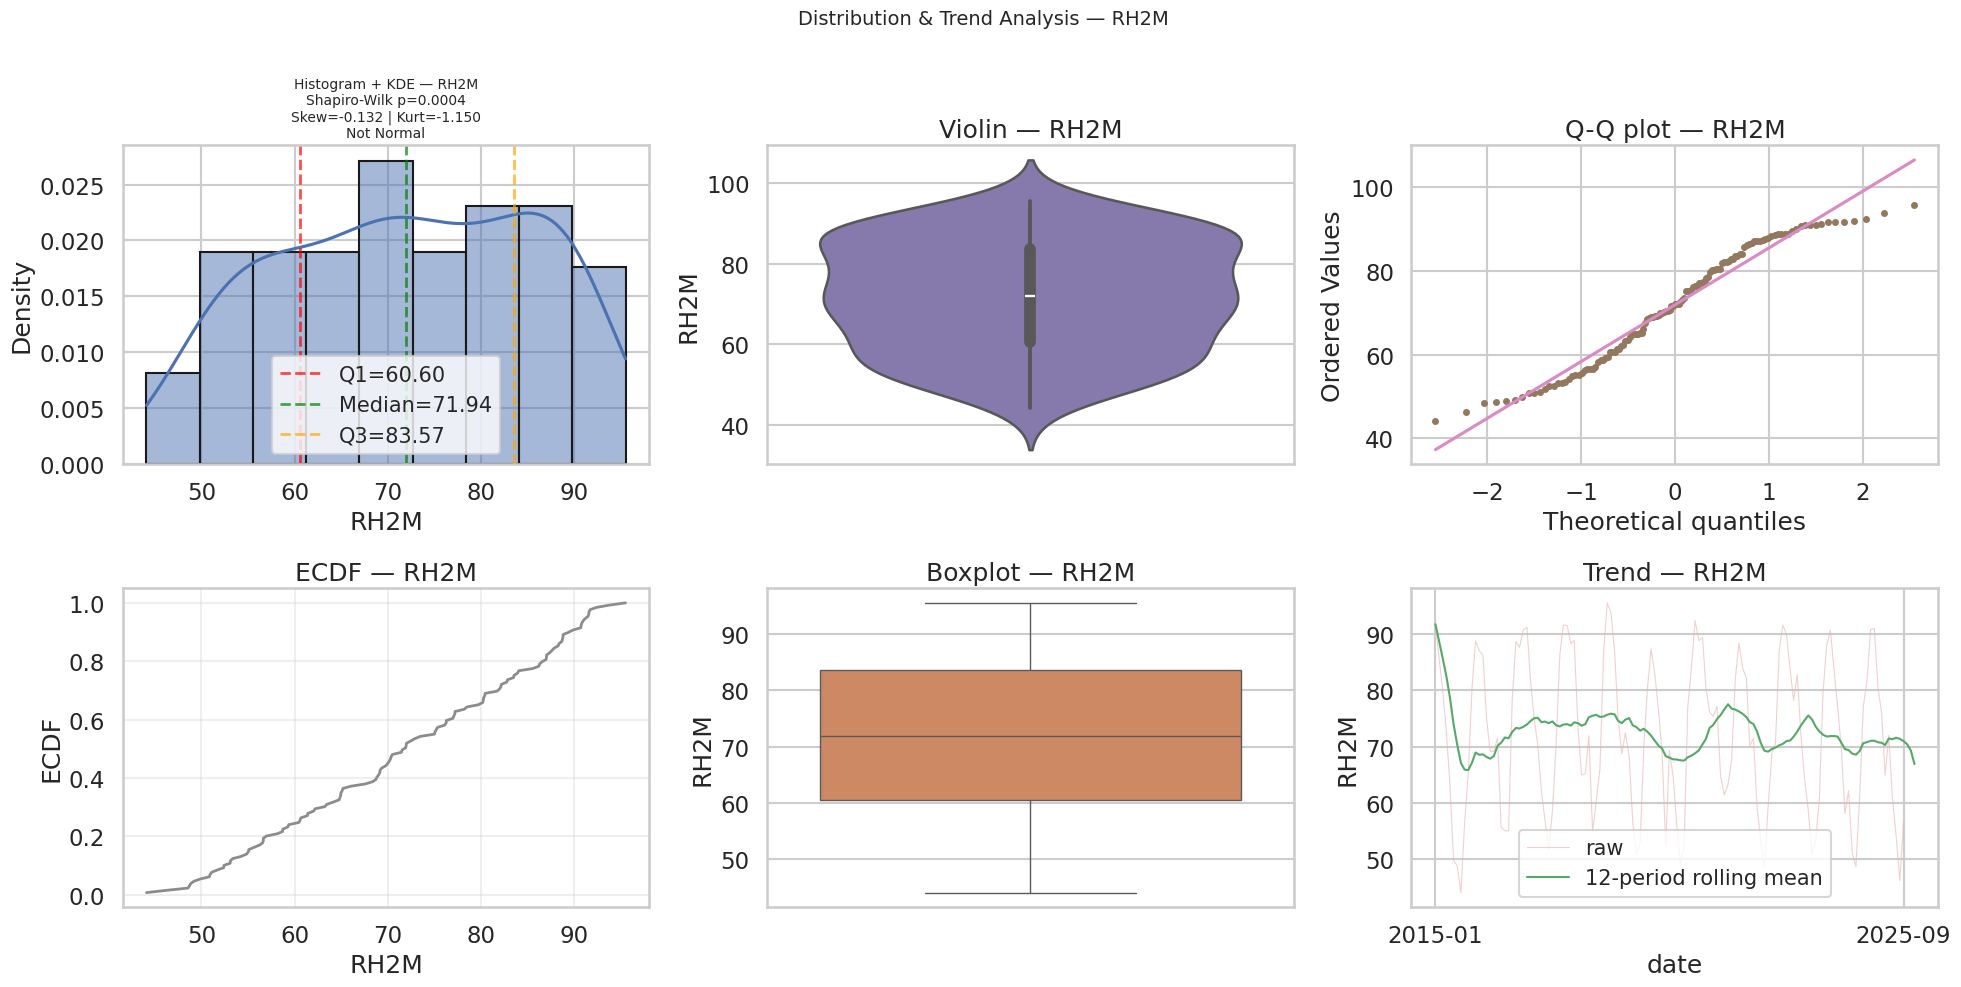

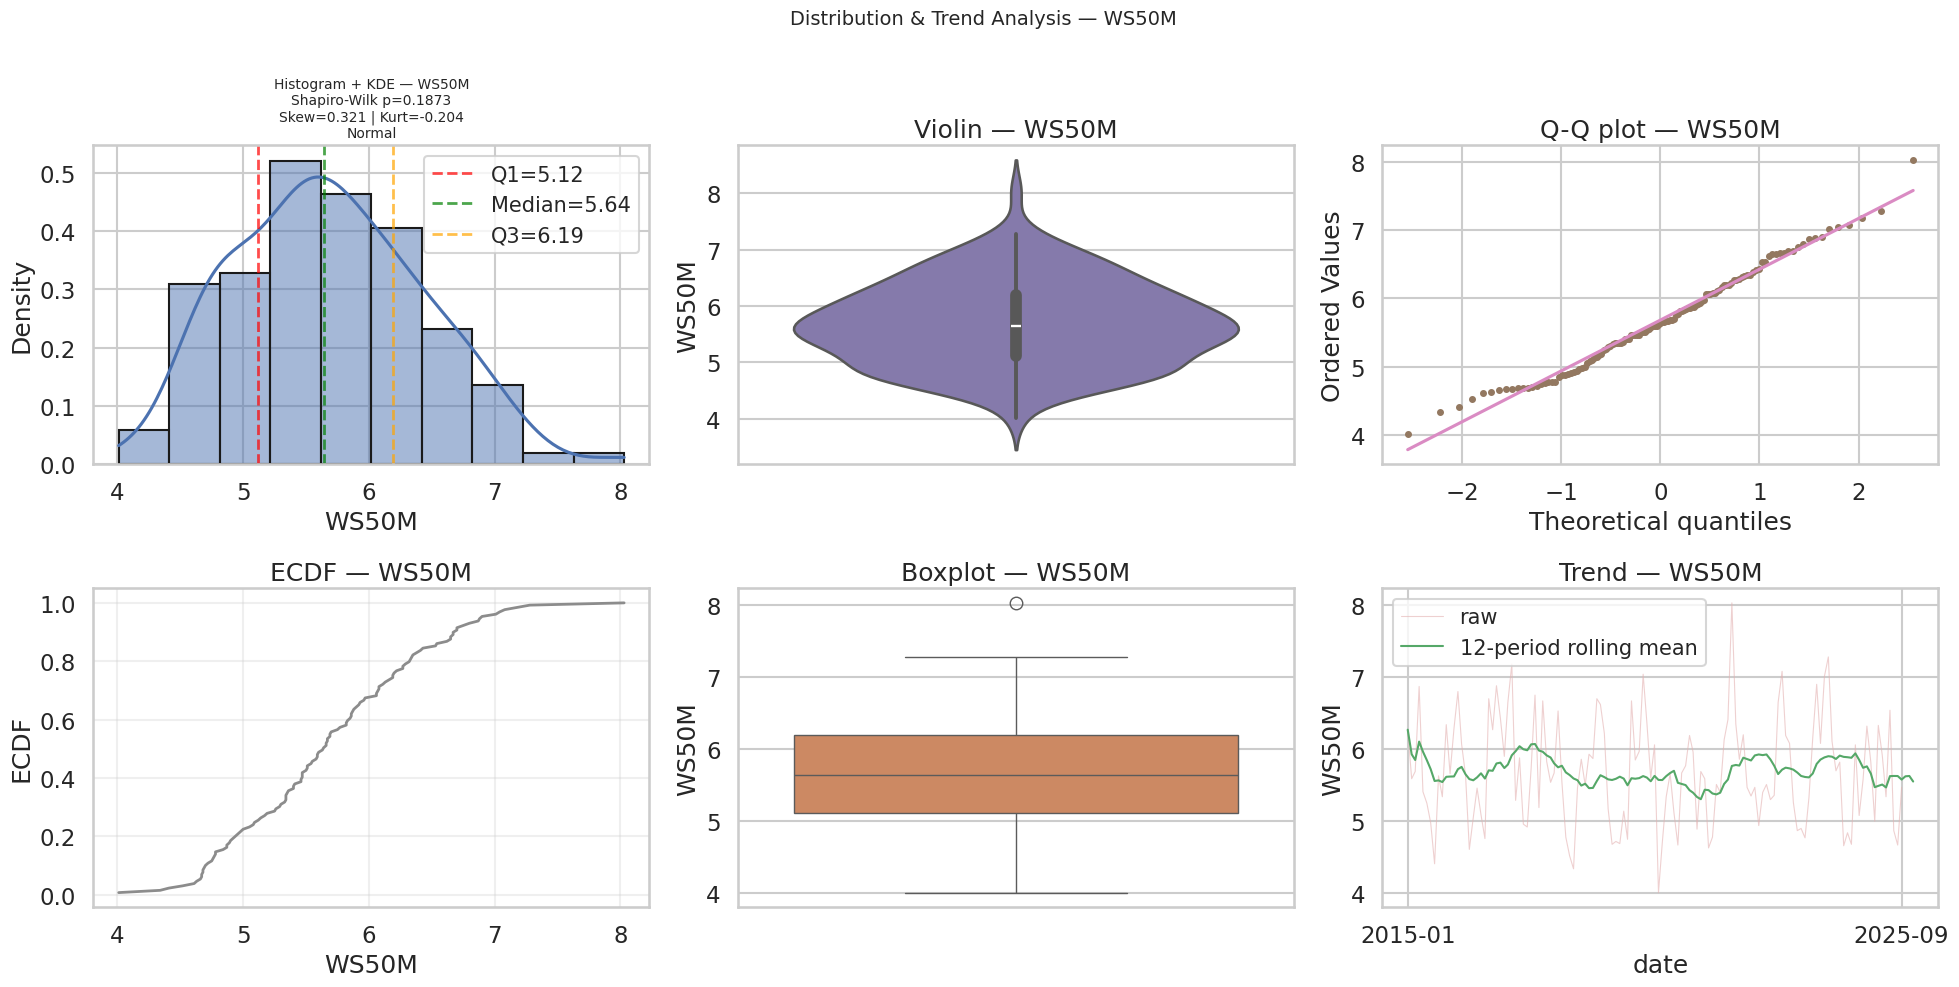

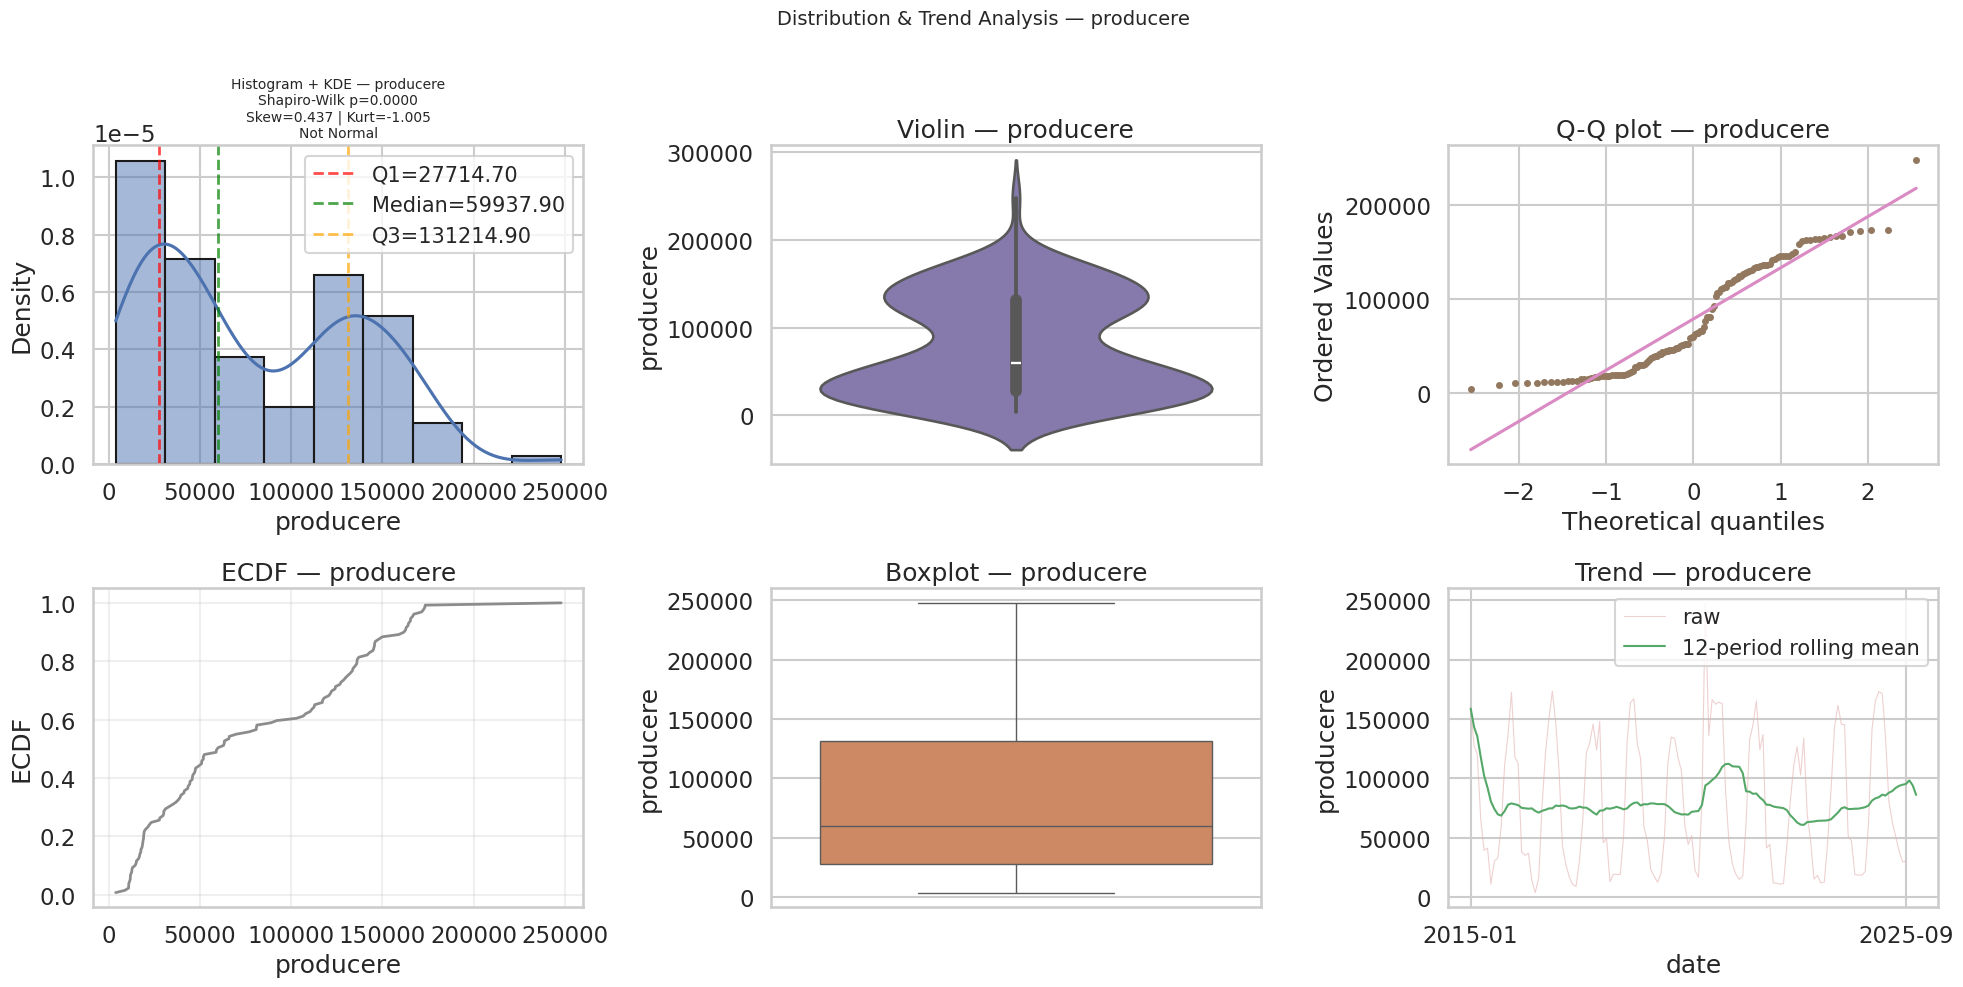

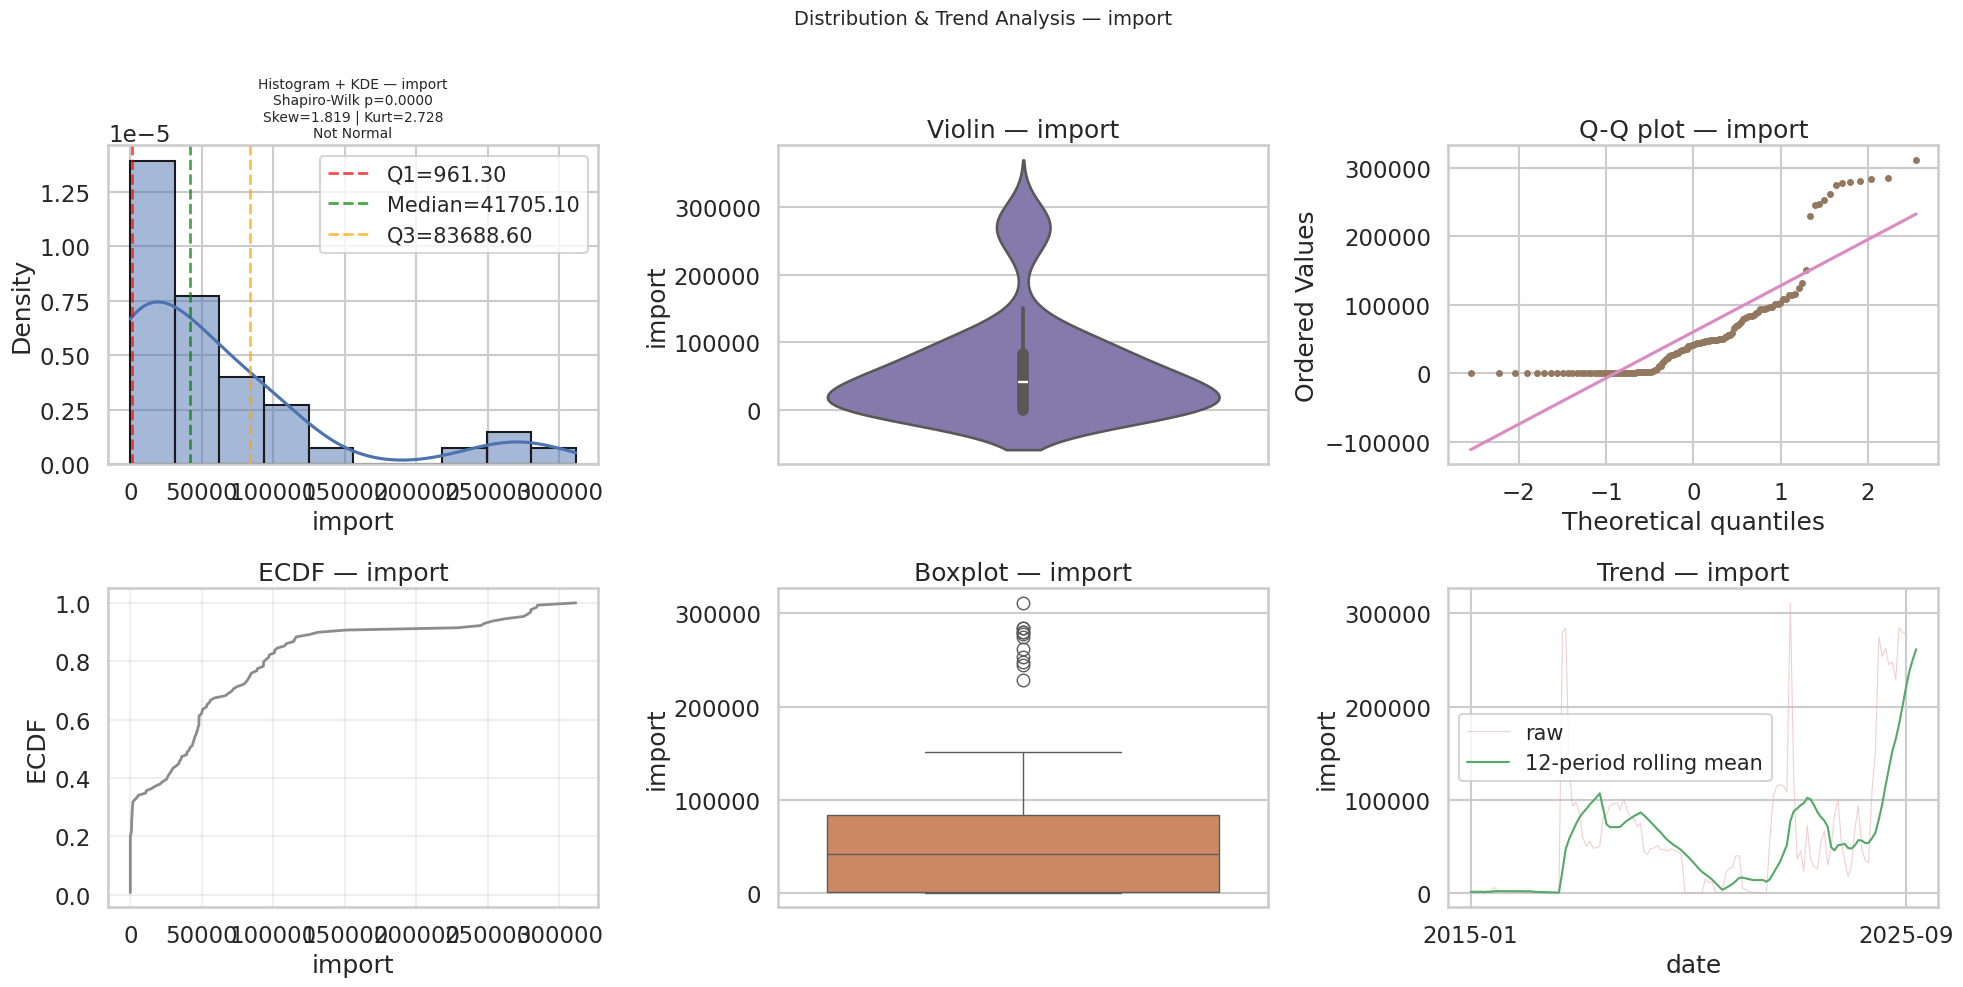

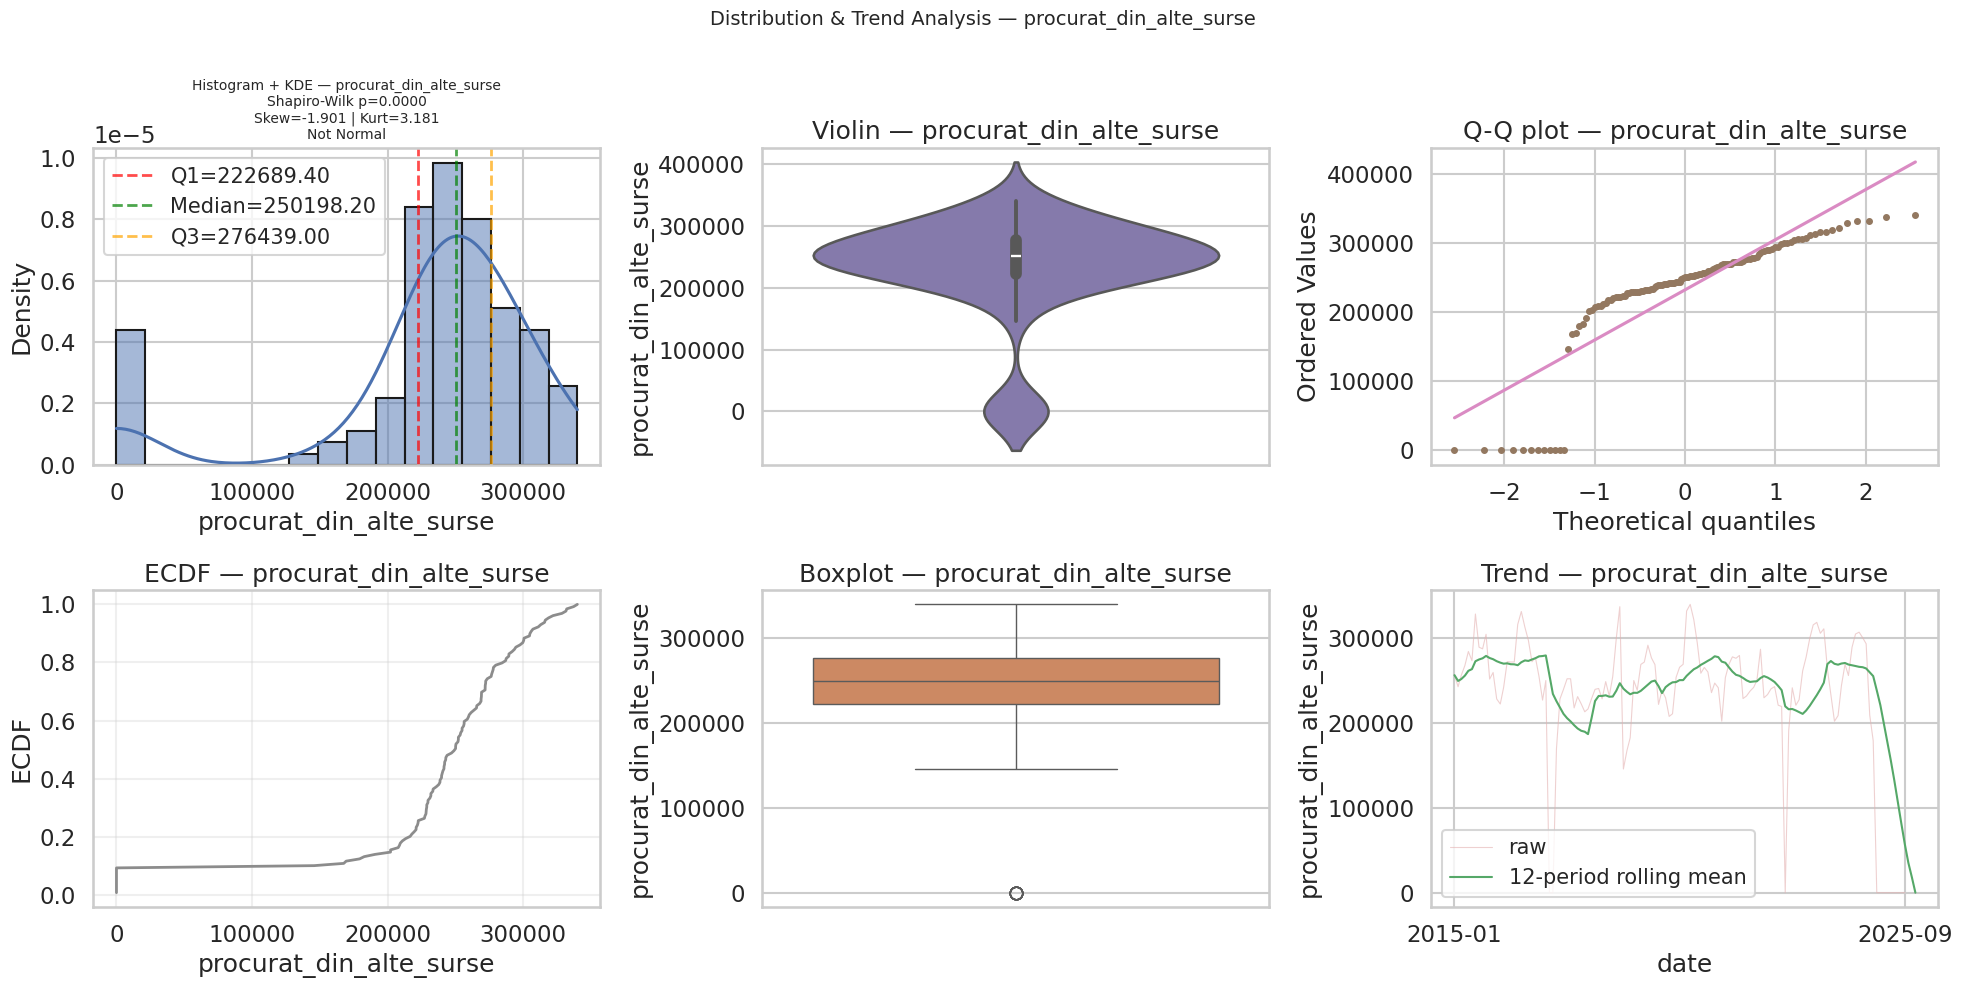

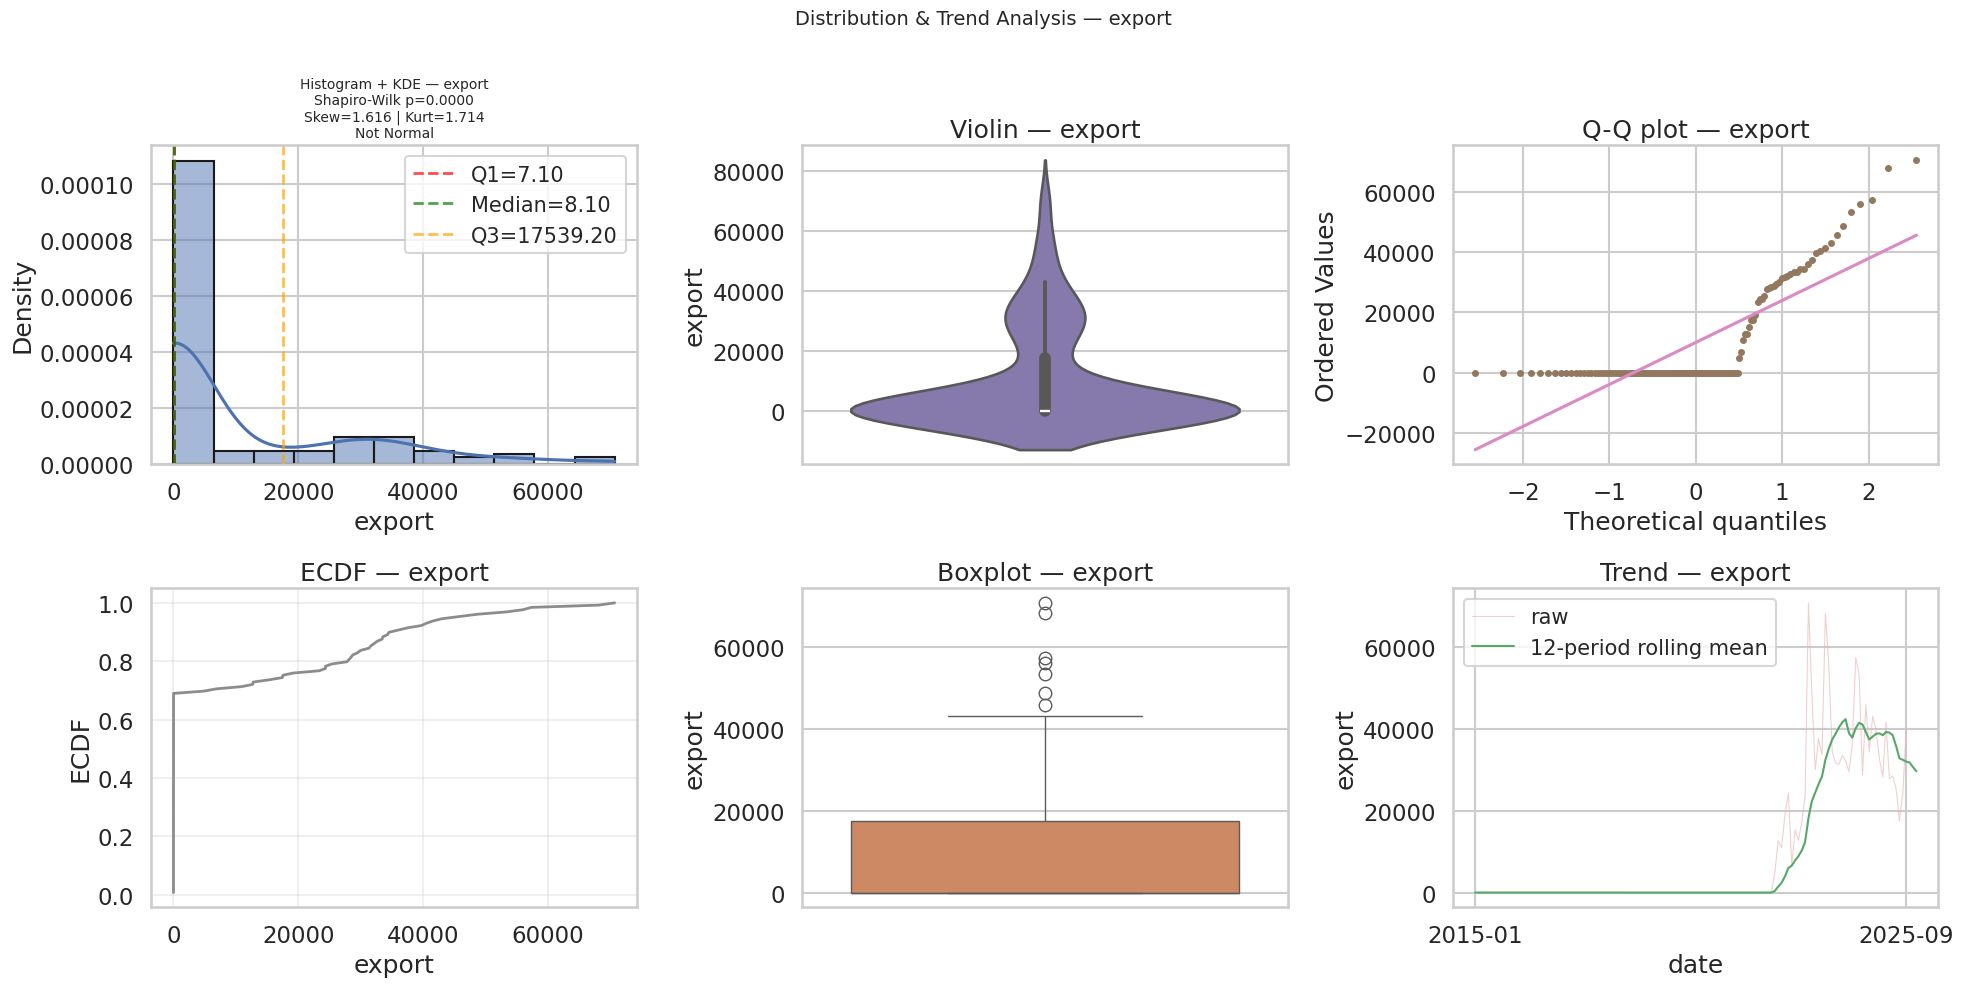

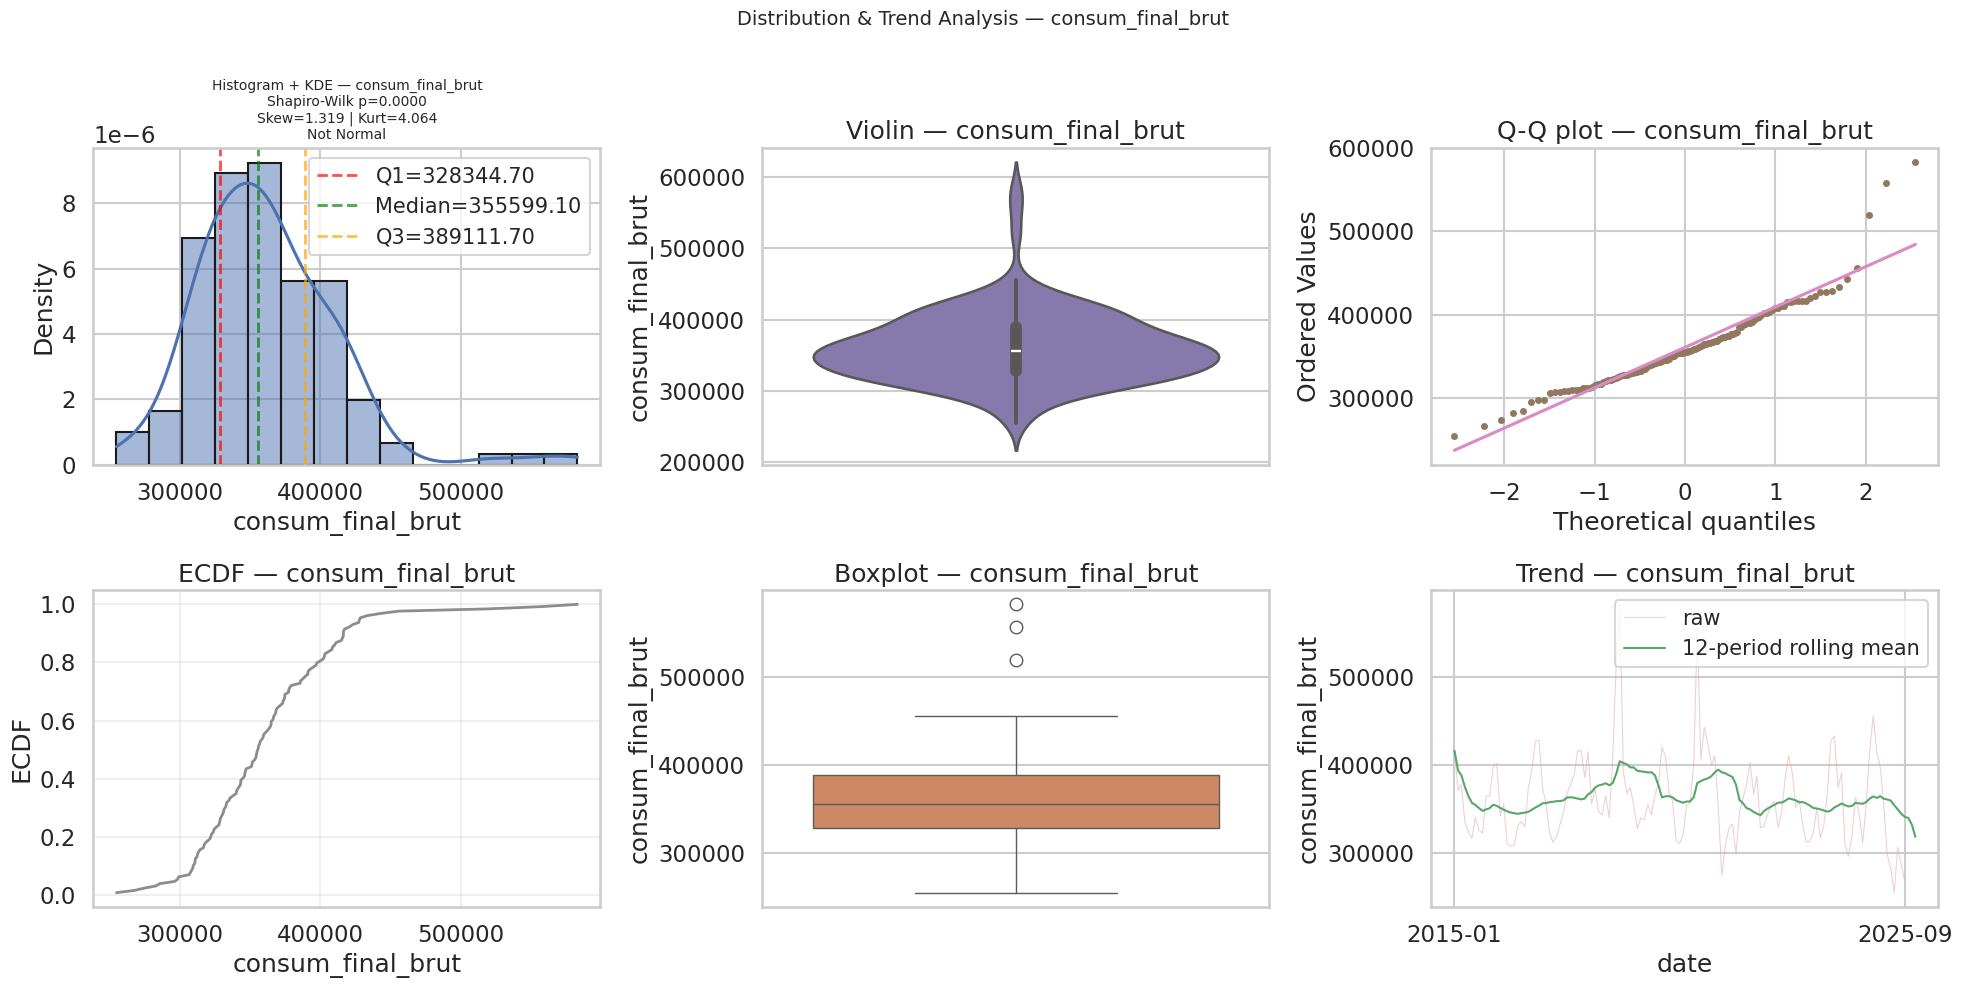

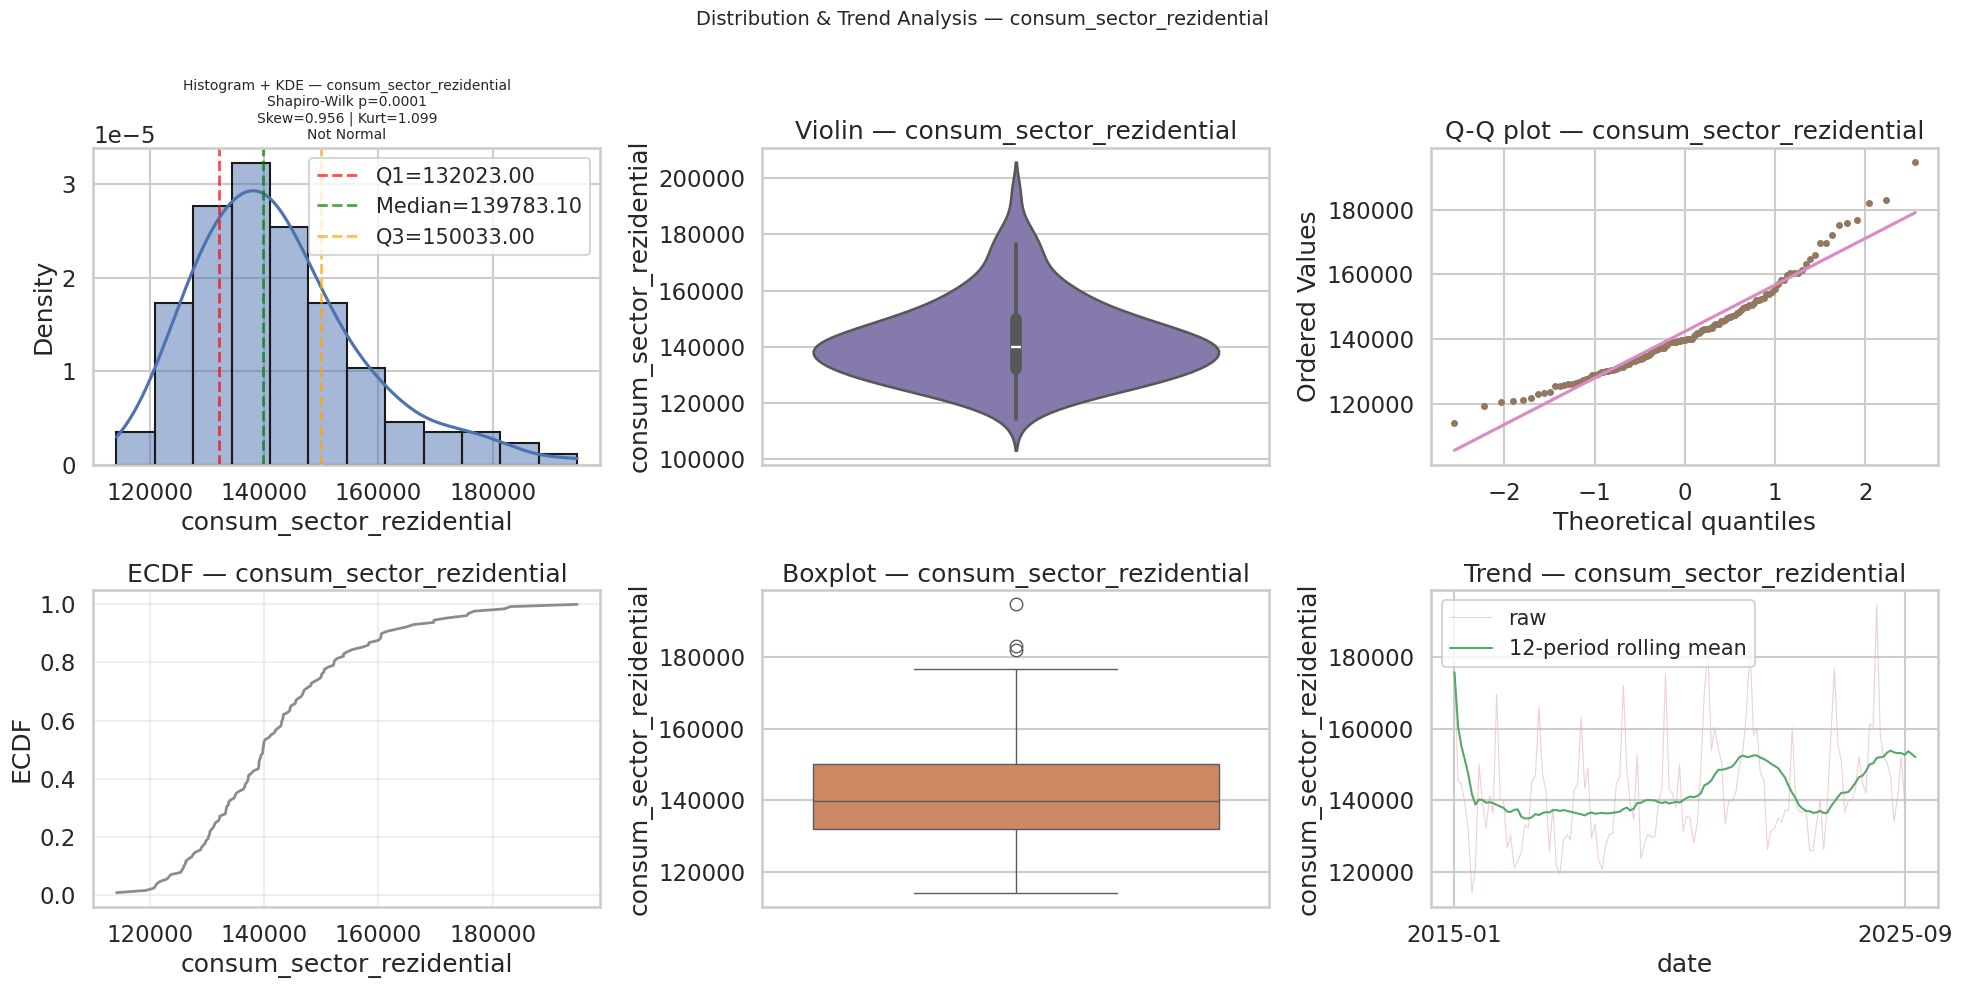

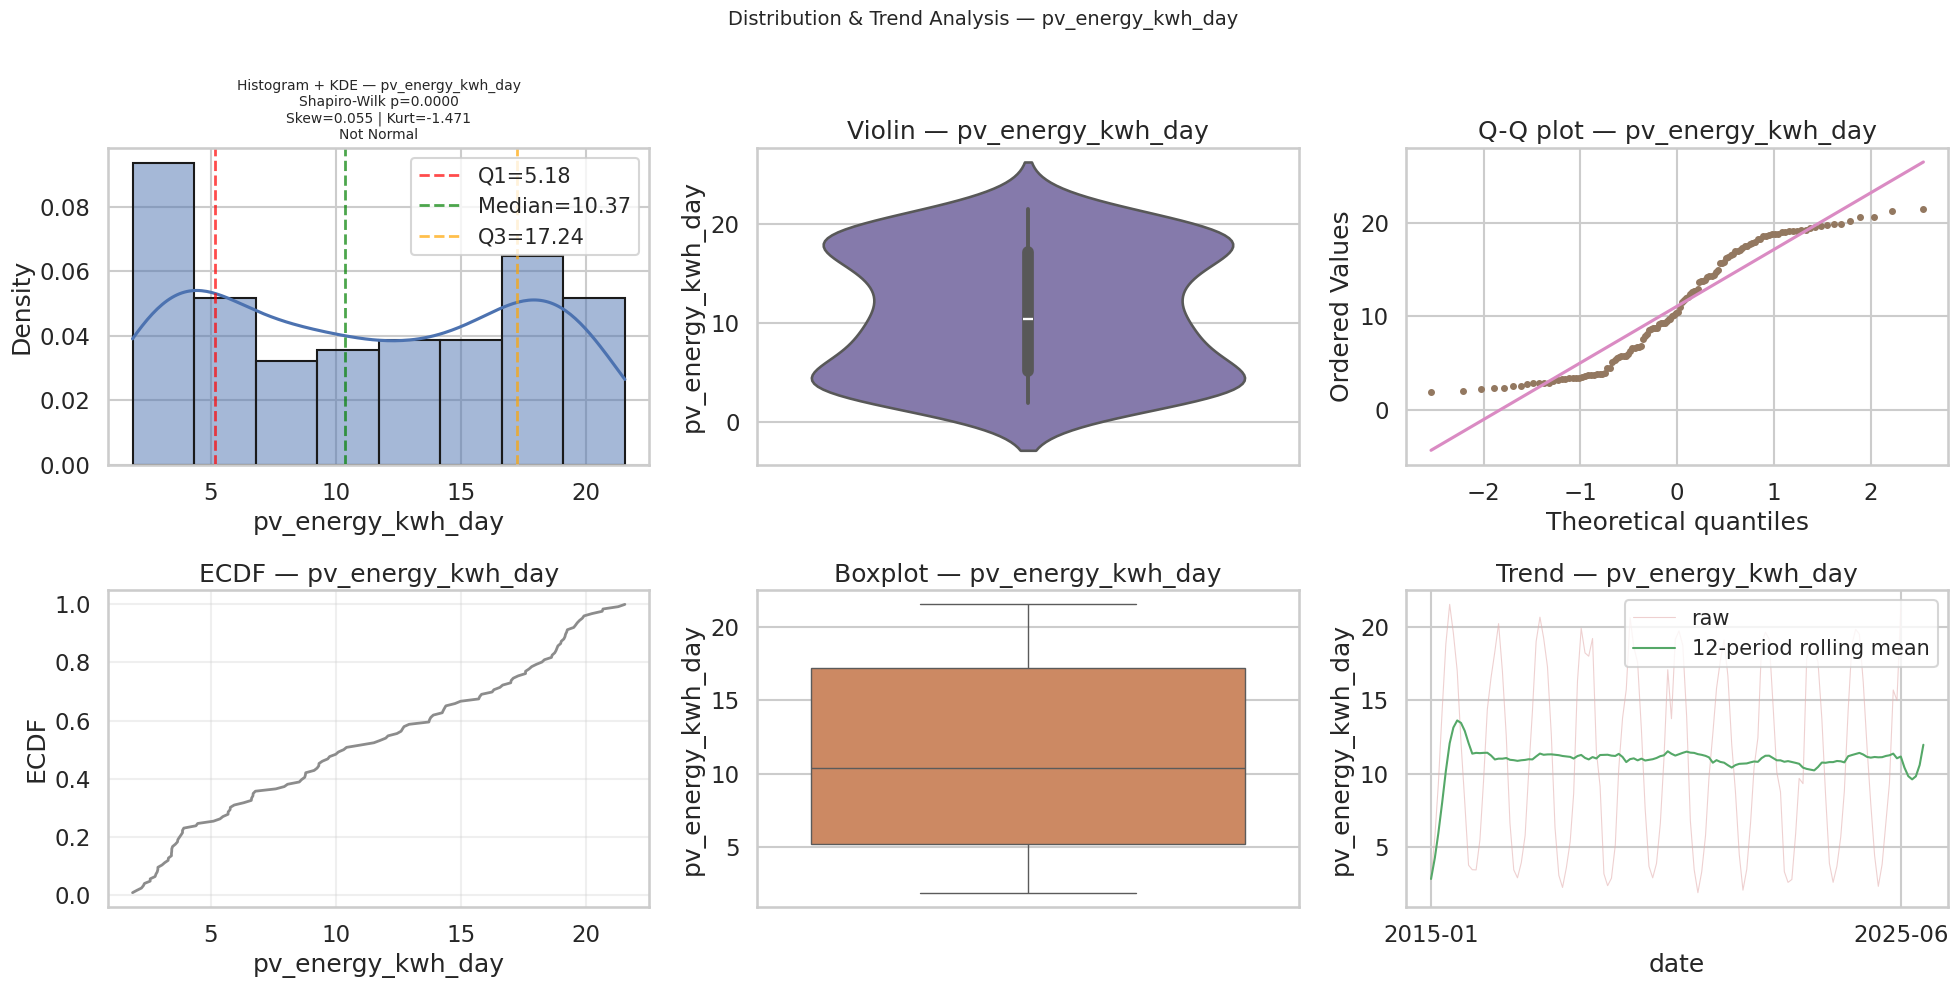

/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


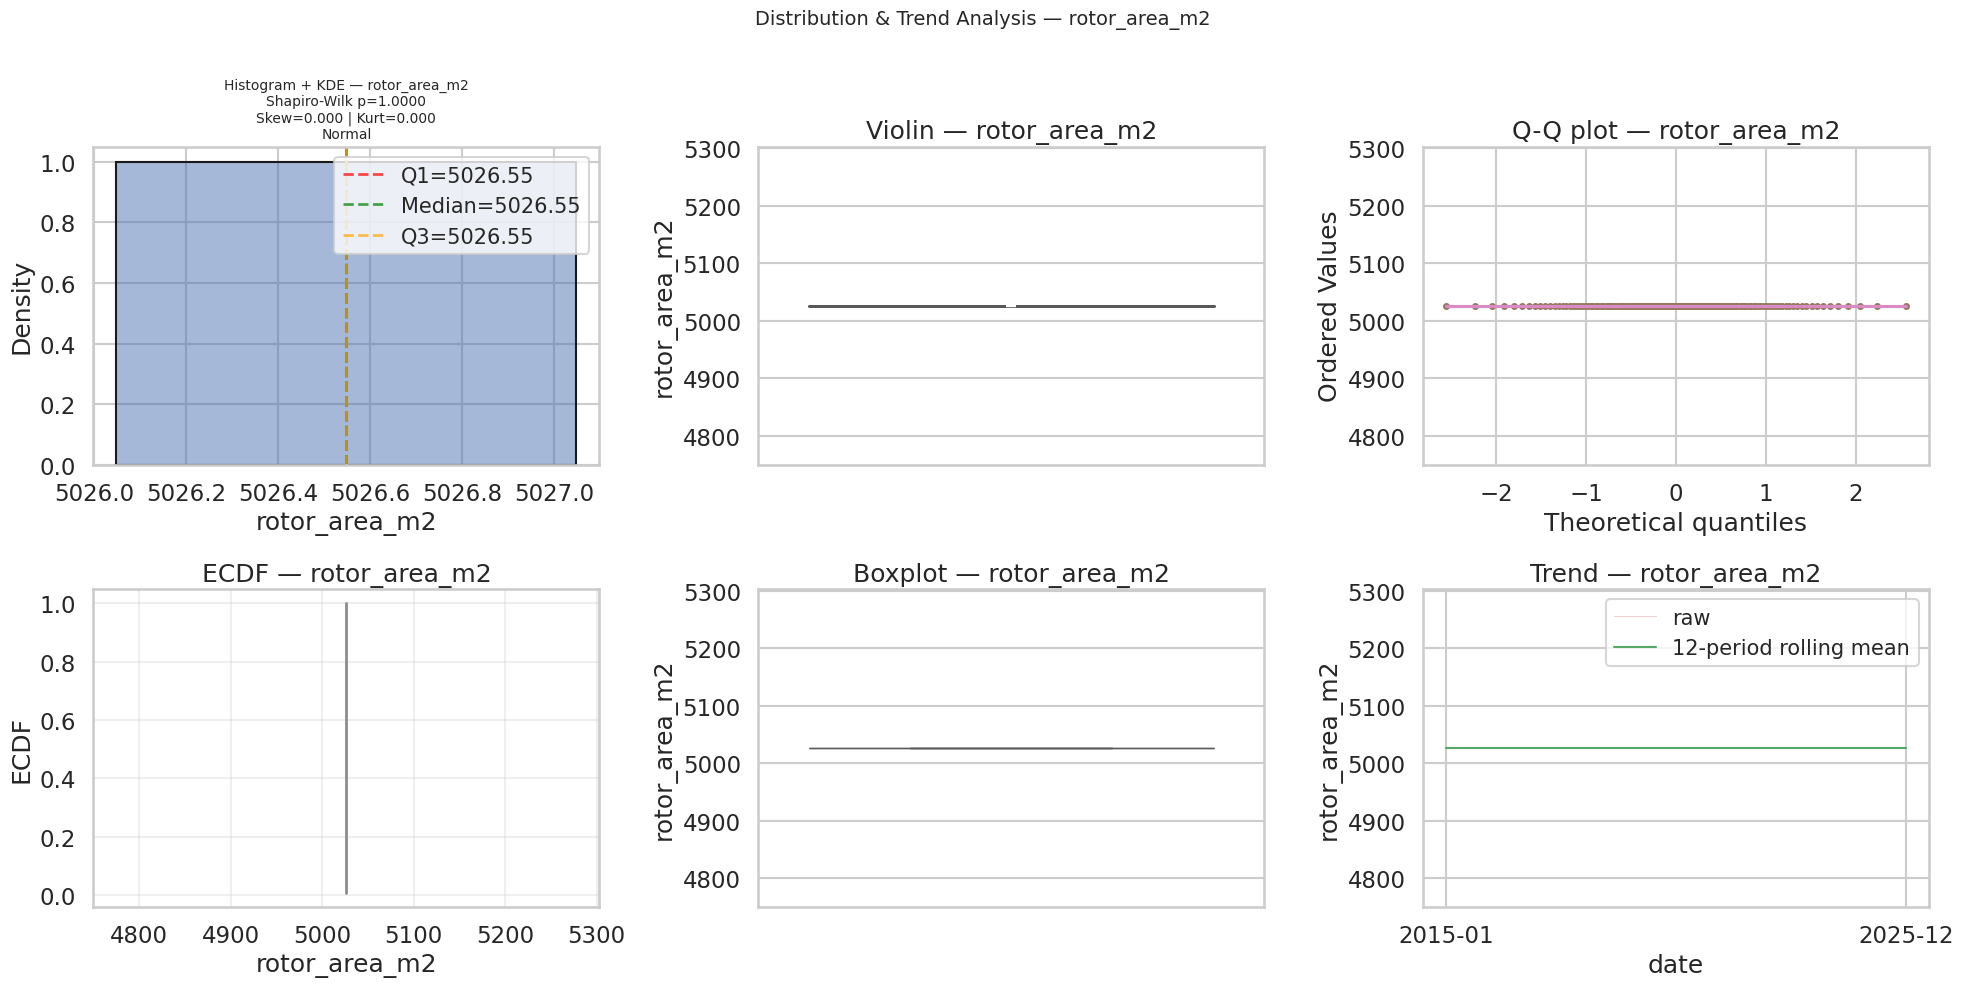

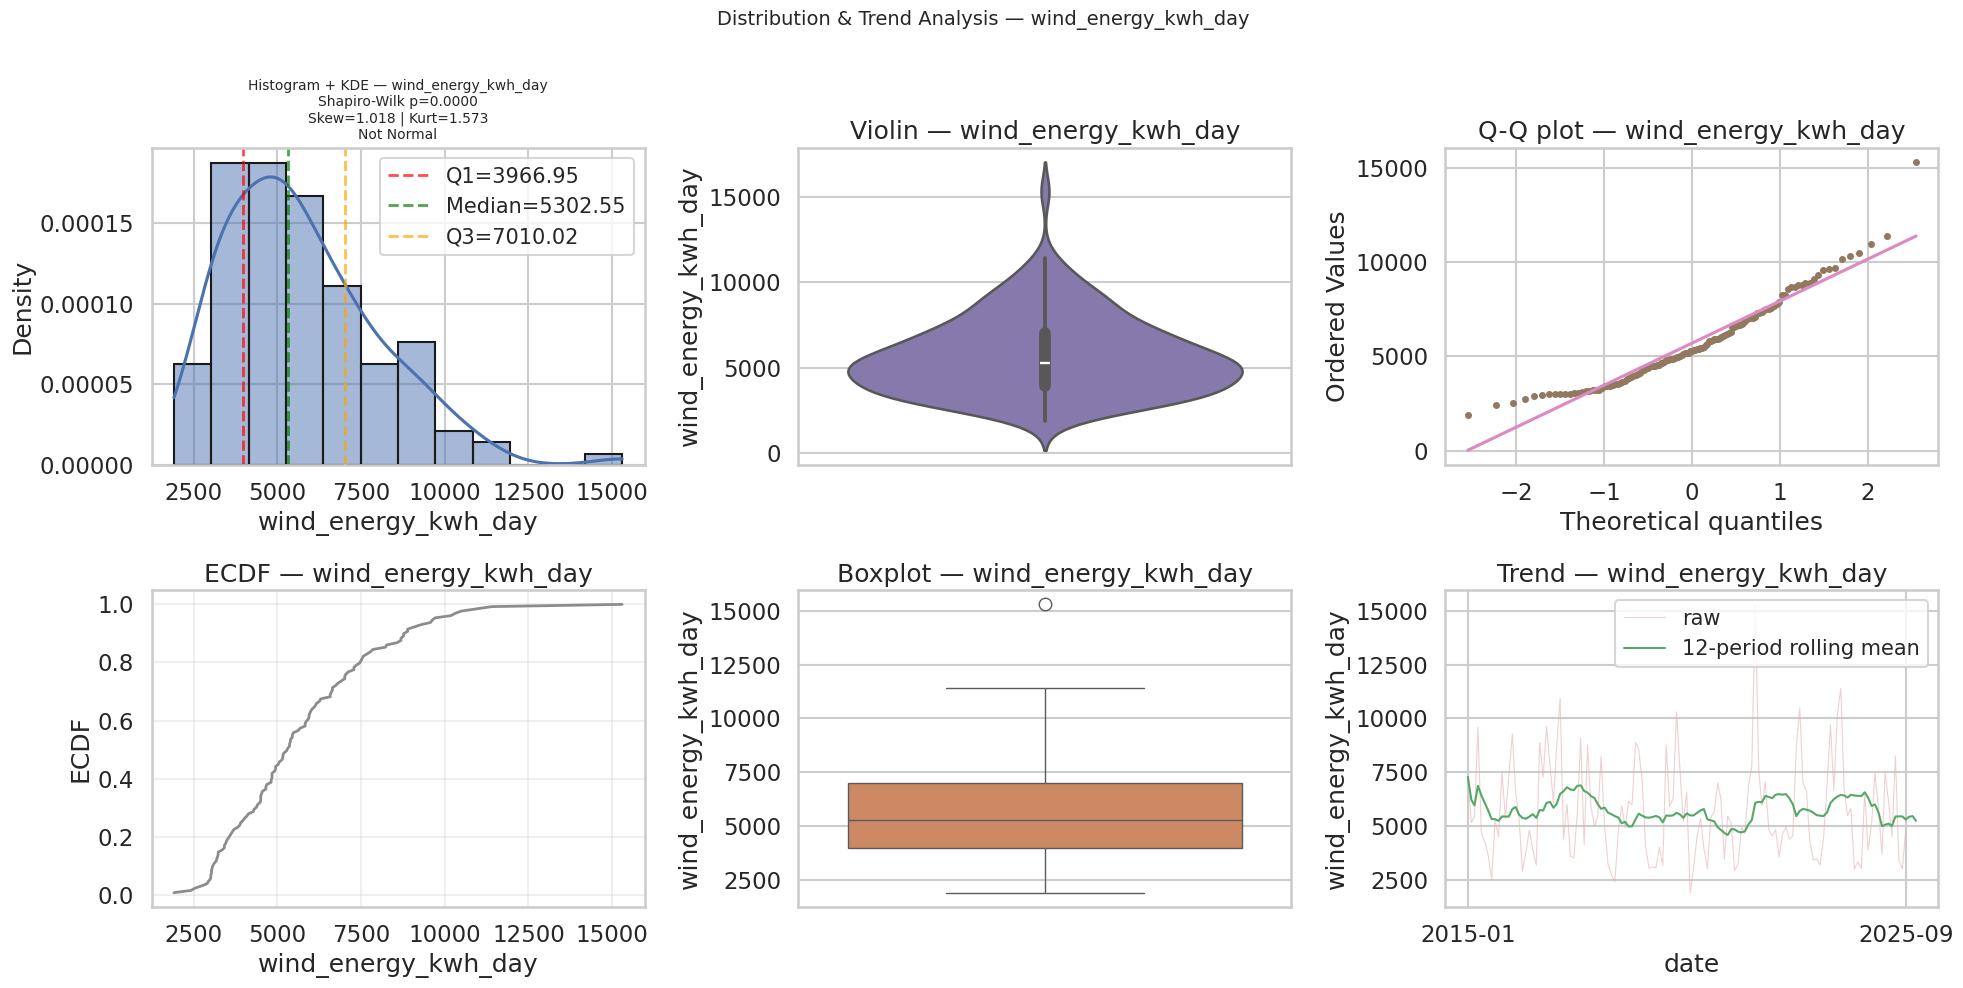

Mean         Std          Min           Q1  \
ALLSKY_SFC_SW_DWN               3.6243      2.0414       0.6134       1.6913   
CLOUD_AMT                      61.7328     15.5007      21.7300      50.5250   
PRECTOTCORR_SUM                46.6430     31.7417       4.3100      23.8200   
PS                             99.9881      0.3751      99.1800      99.7300   
RH2M                           71.8531     13.6198      44.1100      60.6000   
T2M                            11.1198      9.5173      -6.9400       2.2100   
WS50M                           5.6822      0.7408       4.0100       5.1200   
producere                   78745.5411  56550.3432    3848.6000   27714.7000   
import                      60441.6178  77068.8476       0.0000     961.3000   
procurat_din_alte_surse    232024.9814  82913.6099       0.0000  222689.4000   
export                      10014.1202  17194.4201       0.0000       7.1000   
consum_final_brut          361198.0233  49889.0469  254467.4000  328344.7000   
consum_sector_rezidential  142374.3512  14617.5587  114167.0000  132023.0000   
pv_energy_kwh_day              11.0903      6.2468       1.8770       5.1755   
rotor_area_m2                5026.5482      0.0000    5026.5482    5026.5482   
wind_energy_kwh_day          5700.4880   2271.6752    1905.8131    3966.9531   

                                Median           Q3          Max  Skewness  \
ALLSKY_SFC_SW_DWN               3.3886       5.6326       7.0416    0.0552   
CLOUD_AMT                      61.2250      75.1775      88.6700   -0.2467   
PRECTOTCORR_SUM                37.9700      61.2300     139.3600    1.2104   
PS                             99.9300     100.1800     101.2200    0.7220   
RH2M                           71.9400      83.5700      95.5300   -0.1325   
T2M                            10.8700      20.4300      26.4600   -0.0106   
WS50M                           5.6400       6.1900       8.0300    0.3214   
producere                   59937.9000  131214.9000  247967.6000    0.4373   
import                      41705.1000   83688.6000  311396.0000    1.8188   
procurat_din_alte_surse    250198.2000  276439.0000  340034.5000   -1.9012   
export                          8.1000   17539.2000   70770.8000    1.6159   
consum_final_brut          355599.1000  389111.7000  583245.2000    1.3185   
consum_sector_rezidential  139783.1000  150033.0000  194767.0000    0.9561   
pv_energy_kwh_day              10.3693      17.2359      21.5473    0.0552   
rotor_area_m2                5026.5482    5026.5482    5026.5482    0.0000   
wind_energy_kwh_day          5302.5466    7010.0179   15303.6075    1.0181   

                           Kurtosis  CV (%)  
ALLSKY_SFC_SW_DWN           -1.4705   56.33  
CLOUD_AMT                   -0.7159   25.11  
PRECTOTCORR_SUM              1.1398   68.05  
PS                           0.8279    0.38  
RH2M                        -1.1500   18.96  
T2M                         -1.3841   85.59  
WS50M                       -0.2037   13.04  
producere                   -1.0051   71.81  
import                       2.7281  127.51  
procurat_din_alte_surse      3.1809   35.73  
export                       1.7137  171.70  
consum_final_brut            4.0643   13.81  
consum_sector_rezidential    1.0993   10.27  
pv_energy_kwh_day           -1.4705   56.33  
rotor_area_m2                0.0000    0.00  
wind_energy_kwh_day          1.5731   39.85

In [11]:
# All distribution plots organized by plot type (not by variable)
sns.set(style="whitegrid", context="talk")
numeric_cols = [c for c in df.select_dtypes(include="number").columns 
                if c not in ("year", "month", "variatia_stocurilor")]

n_vars = len(numeric_cols)
cols = 4
rows = math.ceil(n_vars / cols)

print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}\n")
for col in numeric_cols:
    s = df[col]
    if s.dropna().empty:
        print(f"Skipping {col}: no data")
        continue

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    series = s.dropna()

    # 1) Histogram + KDE with percentiles, normality test, skewness & kurtosis
    stat, p_value = stats.shapiro(series)
    skewness = series.skew()
    kurtosis = series.kurtosis()
    normality_text = f"Shapiro-Wilk p={p_value:.4f}\nSkew={skewness:.3f} | Kurt={kurtosis:.3f}\n{'Normal' if p_value > 0.05 else 'Not Normal'}"
    
    ax = axes[0]
    sns.histplot(series, kde=True, ax=ax, color="C0", edgecolor="k", stat="density")
    ax.set_title(f"Histogram + KDE — {col}\n{normality_text}", fontsize=10)
    ax.set_ylabel("Density")
    
    # Overlay quartiles/percentiles
    q1, q2, q3 = series.quantile([0.25, 0.5, 0.75])
    ax.axvline(q1, color="red", linestyle="--", linewidth=2, alpha=0.7, label=f"Q1={q1:.2f}")
    ax.axvline(q2, color="green", linestyle="--", linewidth=2, alpha=0.7, label=f"Median={q2:.2f}")
    ax.axvline(q3, color="orange", linestyle="--", linewidth=2, alpha=0.7, label=f"Q3={q3:.2f}")
    ax.legend(fontsize="small", loc="best")

    # 2) Violin plot
    ax = axes[1]
    sns.violinplot(y=series, ax=ax, color="C4")
    ax.set_title(f"Violin — {col}")
    ax.set_ylabel(col)

    # 3) Q-Q plot
    ax = axes[2]
    stats.probplot(series, dist="norm", plot=ax)
    ax.set_title(f"Q-Q plot — {col}")
    ax.get_lines()[0].set_color("C5")
    ax.get_lines()[0].set_marker("o")
    ax.get_lines()[0].set_markersize(4)
    ax.get_lines()[1].set_color("C6")

    # 4) ECDF plot
    ax = axes[3]
    sorted_series = np.sort(series)
    ecdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    ax.plot(sorted_series, ecdf, linewidth=2, color="C7")
    ax.set_title(f"ECDF — {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)

    # 5) Boxplot
    ax = axes[4]
    sns.boxplot(y=series, ax=ax, color="C1")
    ax.set_title(f"Boxplot — {col}")
    ax.set_ylabel(col)

    # 6) Trend plot (raw + 12-period rolling mean)
    ax = axes[5]
    s_full = df[col]
    ax.plot(s_full.index, s_full.values, color="#e4b2b2", linewidth=0.8, alpha=0.6, label="raw")
    rolling = s_full.rolling(window=12, min_periods=1, center=False).mean()
    ax.plot(rolling.index, rolling.values, linestyle="-", color="C2", linewidth=1.5, label="12-period rolling mean")
    ax.set_title(f"Trend — {col}")
    ax.set_xlabel("date")
    ax.set_ylabel(col)
    date_range = s_full.index[~s_full.isna()]
    if len(date_range) > 0:
        ax.set_xticks([date_range[0], date_range[-1]])
        ax.set_xticklabels([date_range[0].strftime('%Y-%m'), date_range[-1].strftime('%Y-%m')], rotation=0)
    ax.legend(fontsize="small", loc="best")

    fig.suptitle(f"Distribution & Trend Analysis — {col}", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# Summary statistics table for all numeric columns
summary_stats = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Std": df[numeric_cols].std(),
    "Min": df[numeric_cols].min(),
    "Q1": df[numeric_cols].quantile(0.25),
    "Median": df[numeric_cols].quantile(0.5),
    "Q3": df[numeric_cols].quantile(0.75),
    "Max": df[numeric_cols].max(),
    "Skewness": df[numeric_cols].skew(),
    "Kurtosis": df[numeric_cols].kurtosis(),
    "CV (%)": (df[numeric_cols].std() / df[numeric_cols].mean() * 100).round(2)
})
display(summary_stats.round(4))

/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


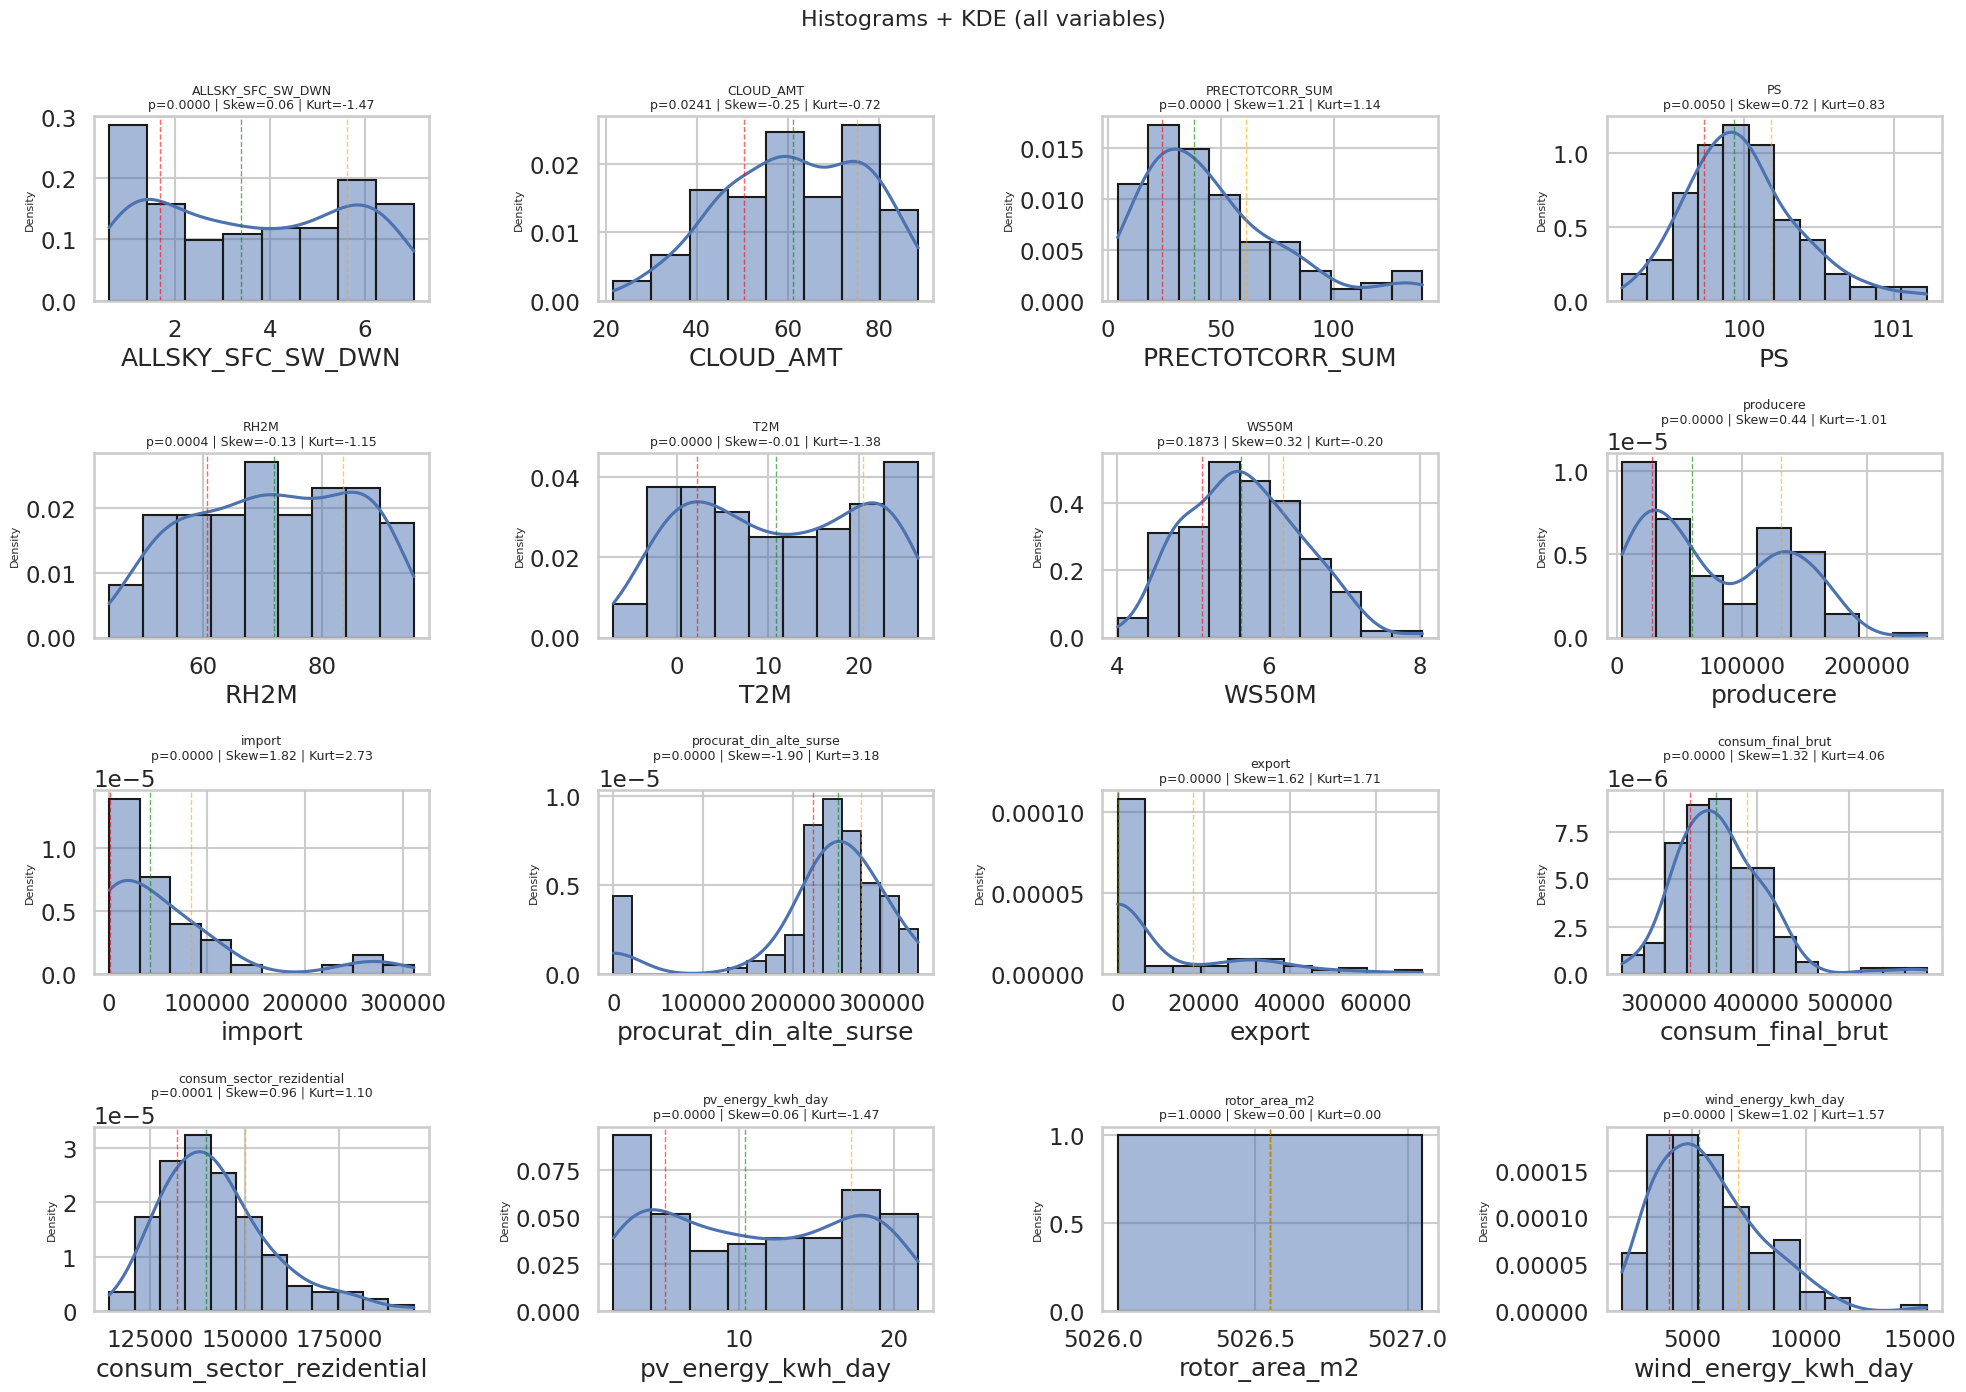

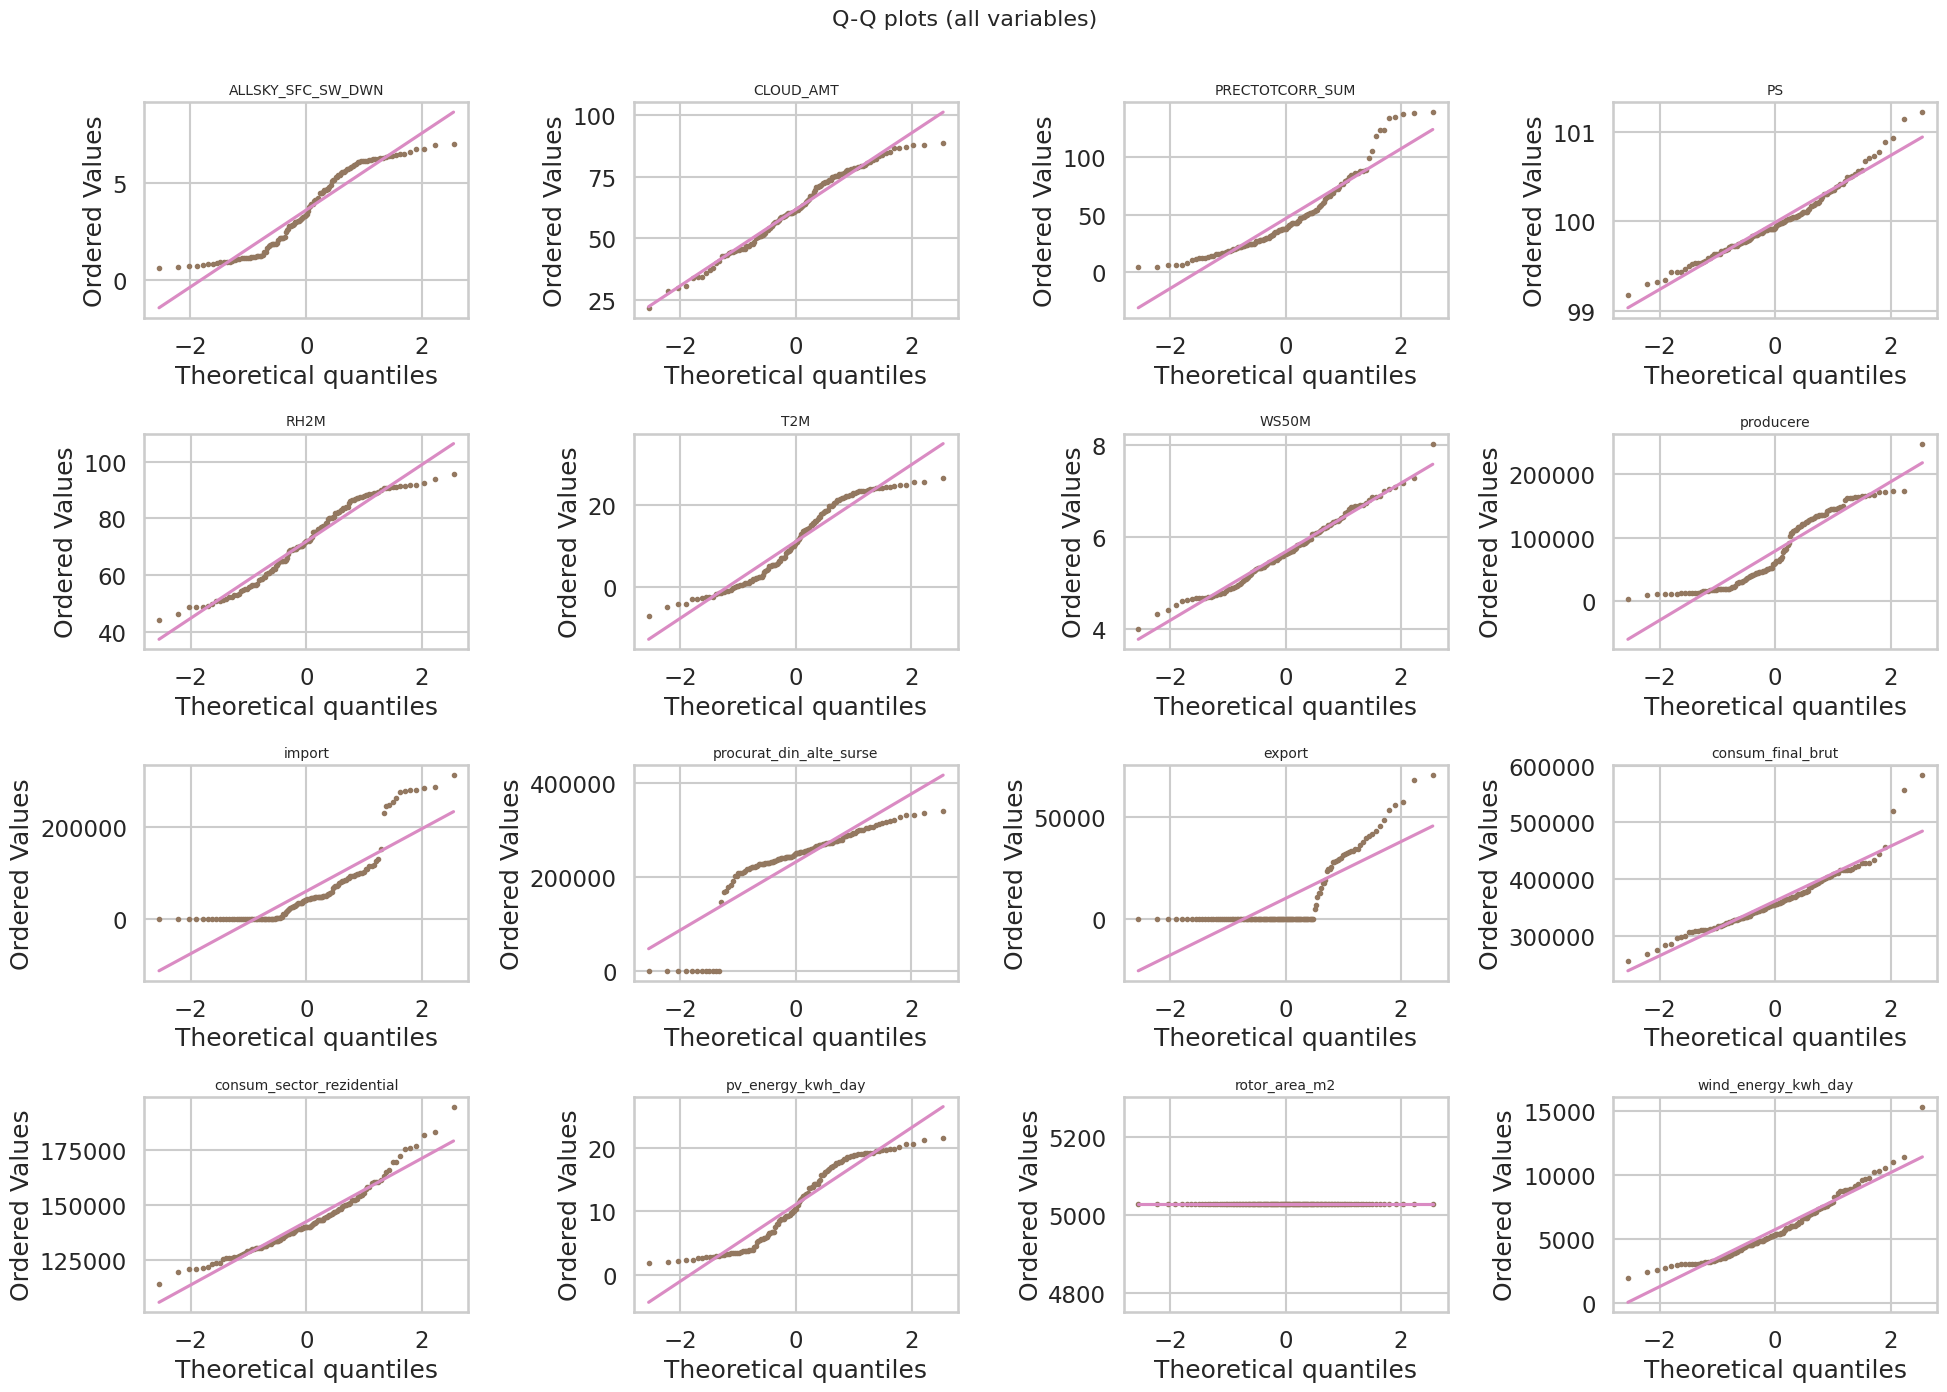

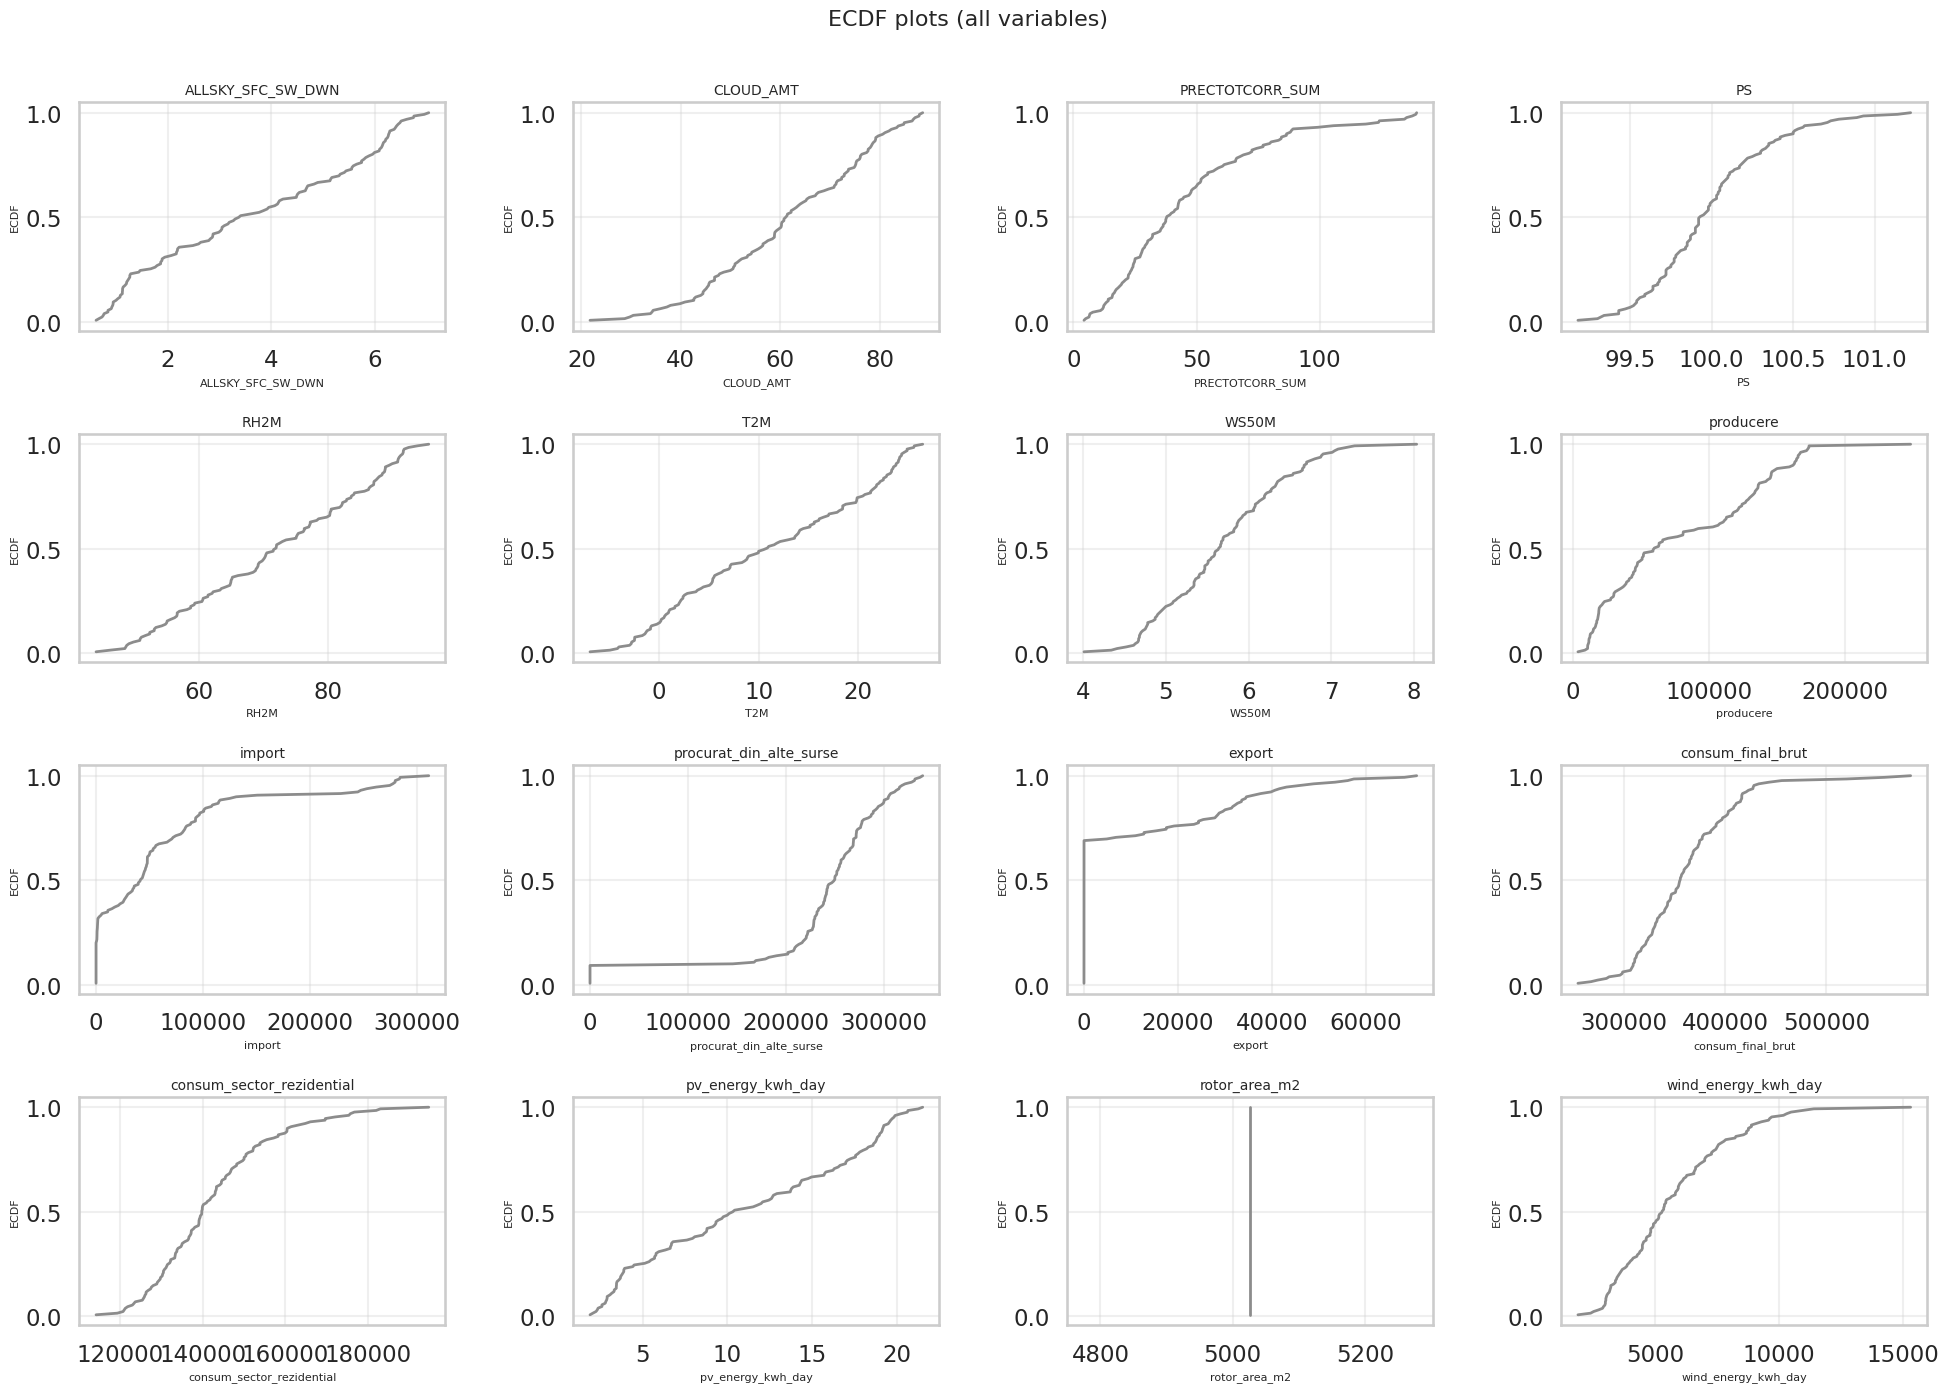

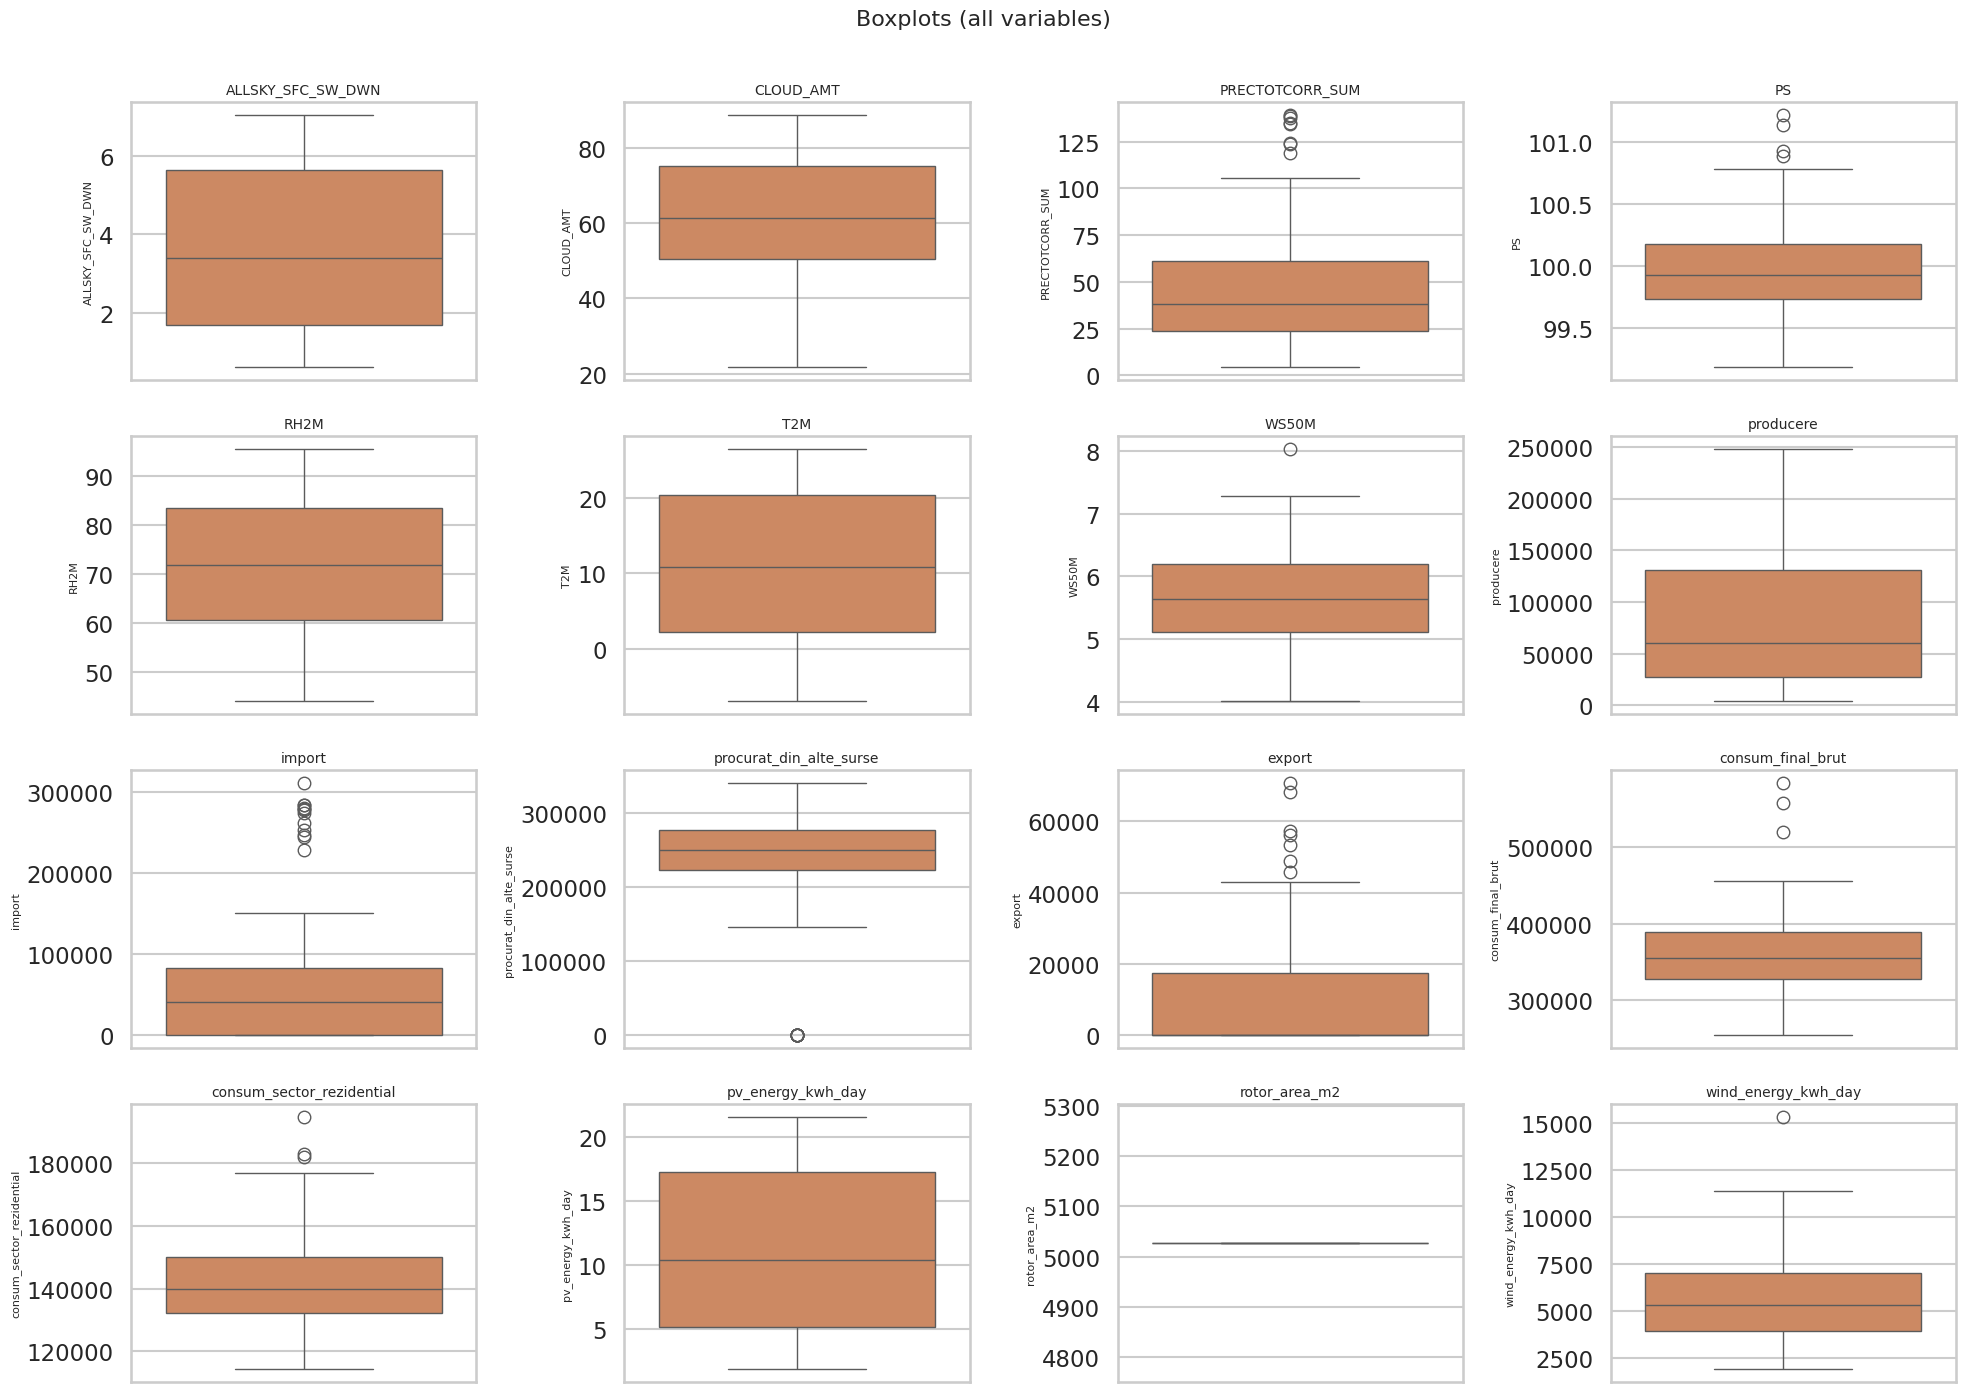

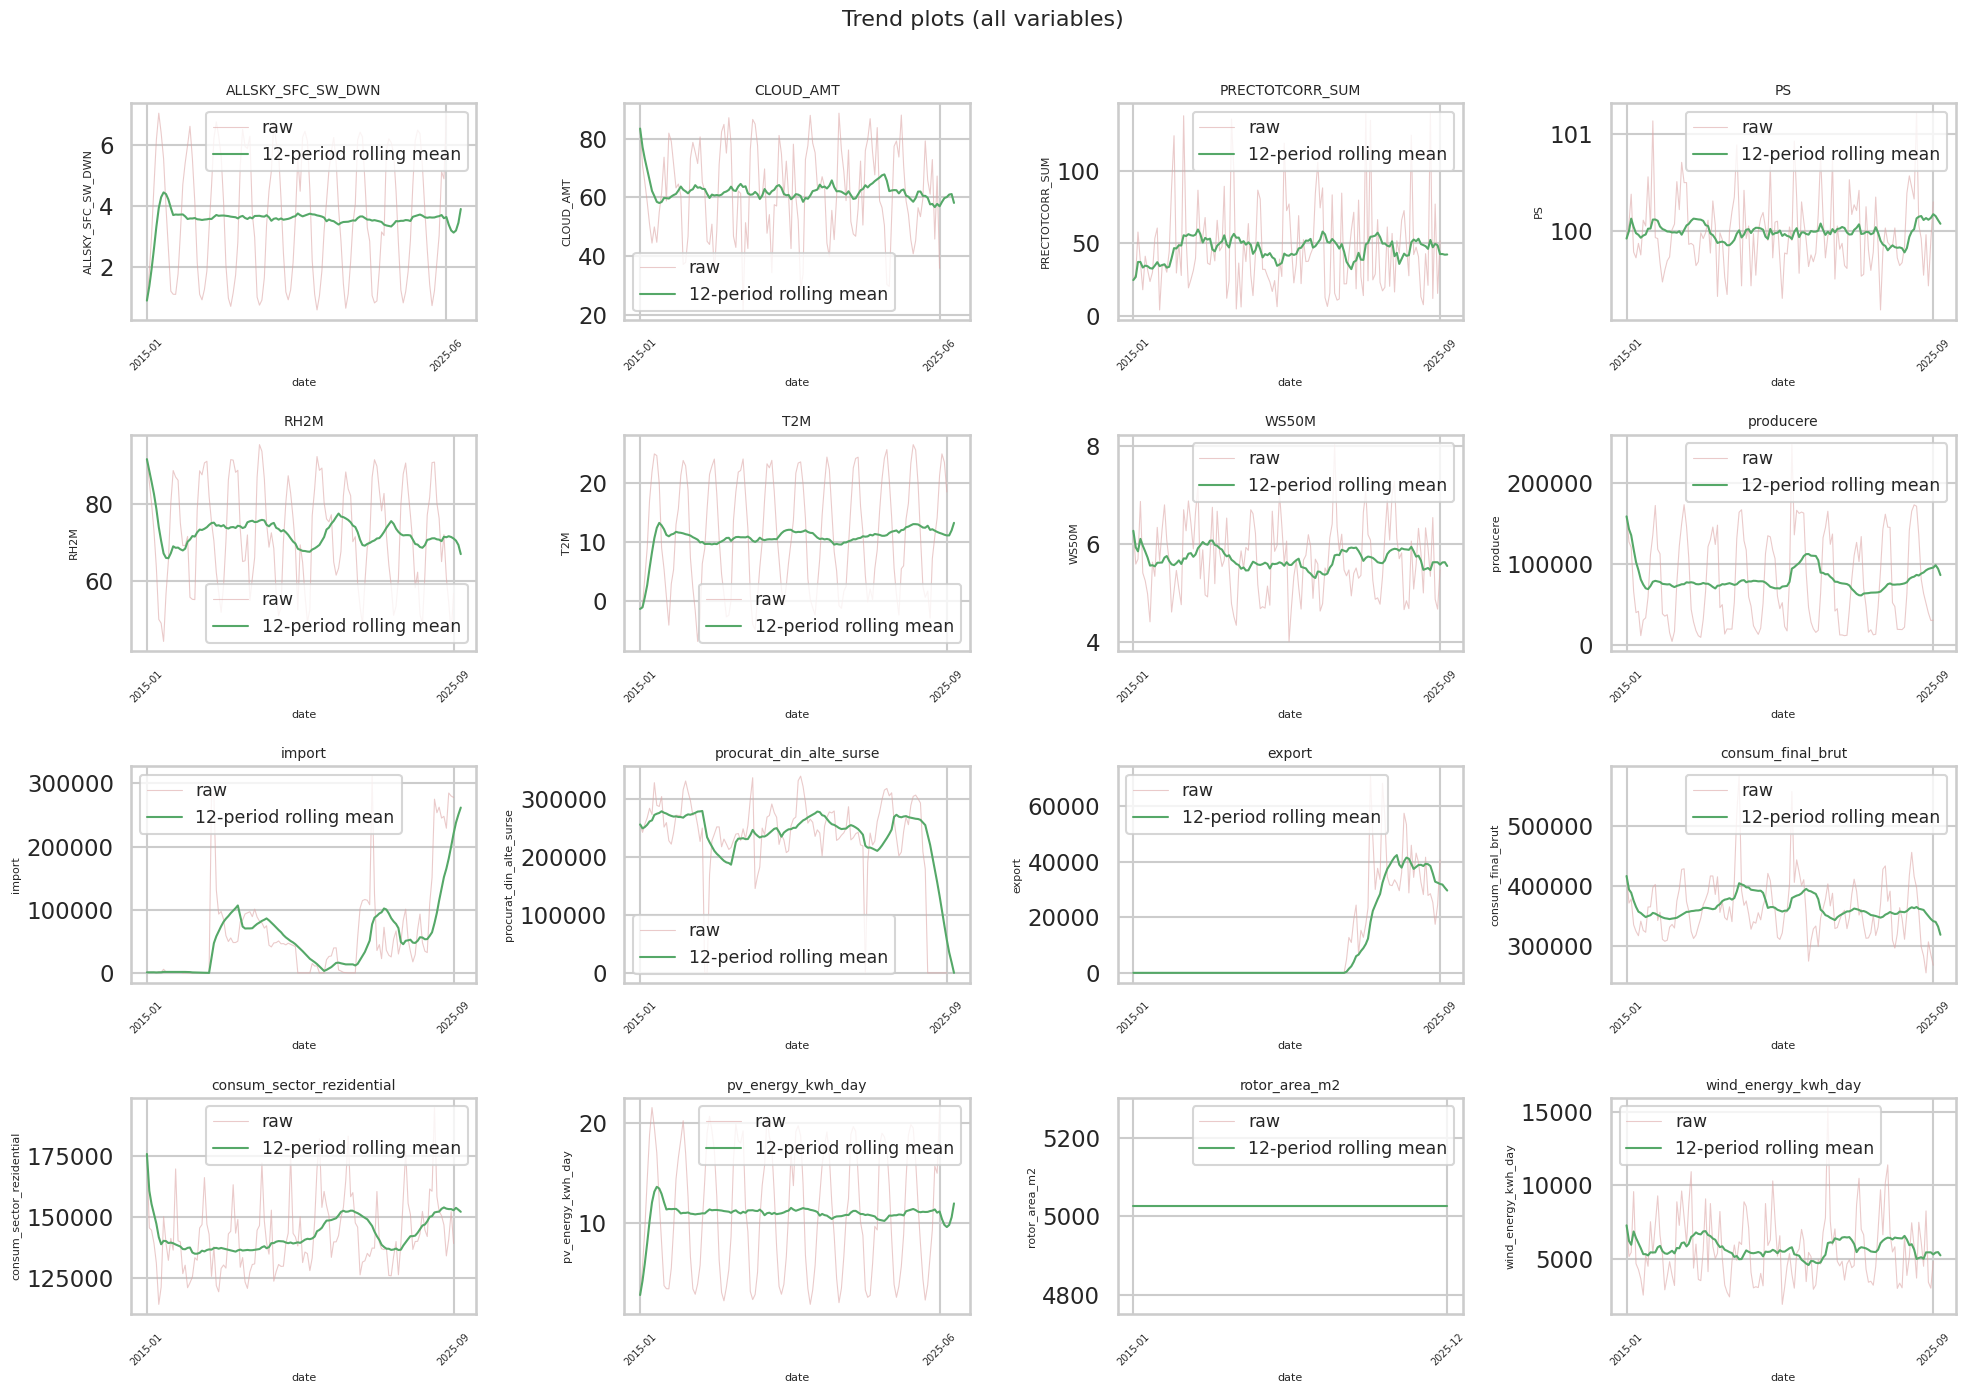

/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Mean         Std          Min           Q1  \
ALLSKY_SFC_SW_DWN               3.6243      2.0414       0.6134       1.6913   
CLOUD_AMT                      61.7328     15.5007      21.7300      50.5250   
PRECTOTCORR_SUM                46.6430     31.7417       4.3100      23.8200   
PS                             99.9881      0.3751      99.1800      99.7300   
RH2M                           71.8531     13.6198      44.1100      60.6000   
T2M                            11.1198      9.5173      -6.9400       2.2100   
WS50M                           5.6822      0.7408       4.0100       5.1200   
producere                   78745.5411  56550.3432    3848.6000   27714.7000   
import                      60441.6178  77068.8476       0.0000     961.3000   
procurat_din_alte_surse    232024.9814  82913.6099       0.0000  222689.4000   
export                      10014.1202  17194.4201       0.0000       7.1000   
consum_final_brut          361198.0233  49889.0469  254467.4000  328344.7000   
consum_sector_rezidential  142374.3512  14617.5587  114167.0000  132023.0000   
pv_energy_kwh_day              11.0903      6.2468       1.8770       5.1755   
rotor_area_m2                5026.5482      0.0000    5026.5482    5026.5482   
wind_energy_kwh_day          5700.4880   2271.6752    1905.8131    3966.9531   

                                Median           Q3          Max  Skewness  \
ALLSKY_SFC_SW_DWN               3.3886       5.6326       7.0416    0.0552   
CLOUD_AMT                      61.2250      75.1775      88.6700   -0.2467   
PRECTOTCORR_SUM                37.9700      61.2300     139.3600    1.2104   
PS                             99.9300     100.1800     101.2200    0.7220   
RH2M                           71.9400      83.5700      95.5300   -0.1325   
T2M                            10.8700      20.4300      26.4600   -0.0106   
WS50M                           5.6400       6.1900       8.0300    0.3214   
producere                   59937.9000  131214.9000  247967.6000    0.4373   
import                      41705.1000   83688.6000  311396.0000    1.8188   
procurat_din_alte_surse    250198.2000  276439.0000  340034.5000   -1.9012   
export                          8.1000   17539.2000   70770.8000    1.6159   
consum_final_brut          355599.1000  389111.7000  583245.2000    1.3185   
consum_sector_rezidential  139783.1000  150033.0000  194767.0000    0.9561   
pv_energy_kwh_day              10.3693      17.2359      21.5473    0.0552   
rotor_area_m2                5026.5482    5026.5482    5026.5482    0.0000   
wind_energy_kwh_day          5302.5466    7010.0179   15303.6075    1.0181   

                           Kurtosis  CV (%)  
ALLSKY_SFC_SW_DWN           -1.4705   56.33  
CLOUD_AMT                   -0.7159   25.11  
PRECTOTCORR_SUM              1.1398   68.05  
PS                           0.8279    0.38  
RH2M                        -1.1500   18.96  
T2M                         -1.3841   85.59  
WS50M                       -0.2037   13.04  
producere                   -1.0051   71.81  
import                       2.7281  127.51  
procurat_din_alte_surse      3.1809   35.73  
export                       1.7137  171.70  
consum_final_brut            4.0643   13.81  
consum_sector_rezidential    1.0993   10.27  
pv_energy_kwh_day           -1.4705   56.33  
rotor_area_m2                0.0000    0.00  
wind_energy_kwh_day          1.5731   39.85

In [12]:
# All distribution plots organized by plot type (not by variable)
sns.set(style="whitegrid", context="talk")
numeric_cols = [c for c in df.select_dtypes(include="number").columns if c not in ("year", "month", "variatia_stocurilor")]

n_vars = len(numeric_cols)
cols = 4
rows = math.ceil(n_vars / cols)

# 1) Grid of Histograms + KDE with normality test
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    stat, p_value = stats.shapiro(series)
    skewness = series.skew()
    kurtosis = series.kurtosis()
    normality_text = f"p={p_value:.4f} | Skew={skewness:.2f} | Kurt={kurtosis:.2f}"
    
    sns.histplot(series, kde=True, ax=ax, color="C0", edgecolor="k", stat="density")
    ax.set_title(f"{col}\n{normality_text}", fontsize=9)
    ax.set_ylabel("Density", fontsize=8)
    
    q1, q2, q3 = series.quantile([0.25, 0.5, 0.75])
    ax.axvline(q1, color="red", linestyle="--", linewidth=1, alpha=0.6)
    ax.axvline(q2, color="green", linestyle="--", linewidth=1, alpha=0.6)
    ax.axvline(q3, color="orange", linestyle="--", linewidth=1, alpha=0.6)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Histograms + KDE (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 2) Grid of Violin plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sns.violinplot(y=series, ax=ax, color="C4")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_ylabel(col, fontsize=8)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Violin plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 3) Grid of Q-Q plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    stats.probplot(series, dist="norm", plot=ax)
    ax.set_title(f"{col}", fontsize=10)
    ax.get_lines()[0].set_color("C5")
    ax.get_lines()[0].set_marker("o")
    ax.get_lines()[0].set_markersize(3)
    ax.get_lines()[1].set_color("C6")

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Q-Q plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 4) Grid of ECDF plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sorted_series = np.sort(series)
    ecdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    ax.plot(sorted_series, ecdf, linewidth=2, color="C7")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("ECDF", fontsize=8)
    ax.grid(True, alpha=0.3)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("ECDF plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 5) Grid of Boxplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sns.boxplot(y=series, ax=ax, color="C1")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_ylabel(col, fontsize=8)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Boxplots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 6) Grid of Trend plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    s_full = df[col]
    ax = axes[i]
    if s_full.dropna().empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    ax.plot(s_full.index, s_full.values, color="#dda8a8", linewidth=0.8, alpha=0.6, label="raw")
    rolling = s_full.rolling(window=12, min_periods=1, center=False).mean()
    ax.plot(rolling.index, rolling.values, linestyle="-", color="C2", linewidth=1.5, label="12-period rolling mean")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_xlabel("date", fontsize=8)
    ax.set_ylabel(col, fontsize=8)
    date_range = s_full.index[~s_full.isna()]
    if len(date_range) > 1:
        ax.set_xticks([date_range[0], date_range[-1]])
        ax.set_xticklabels([date_range[0].strftime('%Y-%m'), date_range[-1].strftime('%Y-%m')], rotation=45, fontsize=7)
    ax.legend(fontsize="x-small", loc="best")

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Trend plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 7) Autocorrelation Analysis (ACF/PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

n_lags = 12  # Monthly lags for yearly patterns
n_plots = len(numeric_cols)
cols = 4
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    
    if len(series) < 3:
        ax.text(0.5, 0.5, "insufficient data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    plot_acf(series, lags=min(n_lags, len(series)//2), ax=ax, alpha=0.05)
    ax.set_title(f"ACF — {col}", fontsize=10)
    ax.set_ylabel("Autocorrelation", fontsize=8)

for j in range(n_plots, len(axes)):
    axes[j].axis("off")

fig.suptitle("Autocorrelation Function (ACF) — Temporal Patterns (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# Summary statistics table
summary_stats = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Std": df[numeric_cols].std(),
    "Min": df[numeric_cols].min(),
    "Q1": df[numeric_cols].quantile(0.25),
    "Median": df[numeric_cols].quantile(0.5),
    "Q3": df[numeric_cols].quantile(0.75),
    "Max": df[numeric_cols].max(),
    "Skewness": df[numeric_cols].skew(),
    "Kurtosis": df[numeric_cols].kurtosis(),
    "CV (%)": (df[numeric_cols].std() / df[numeric_cols].mean() * 100).round(2)
})
display(summary_stats.round(4))



/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


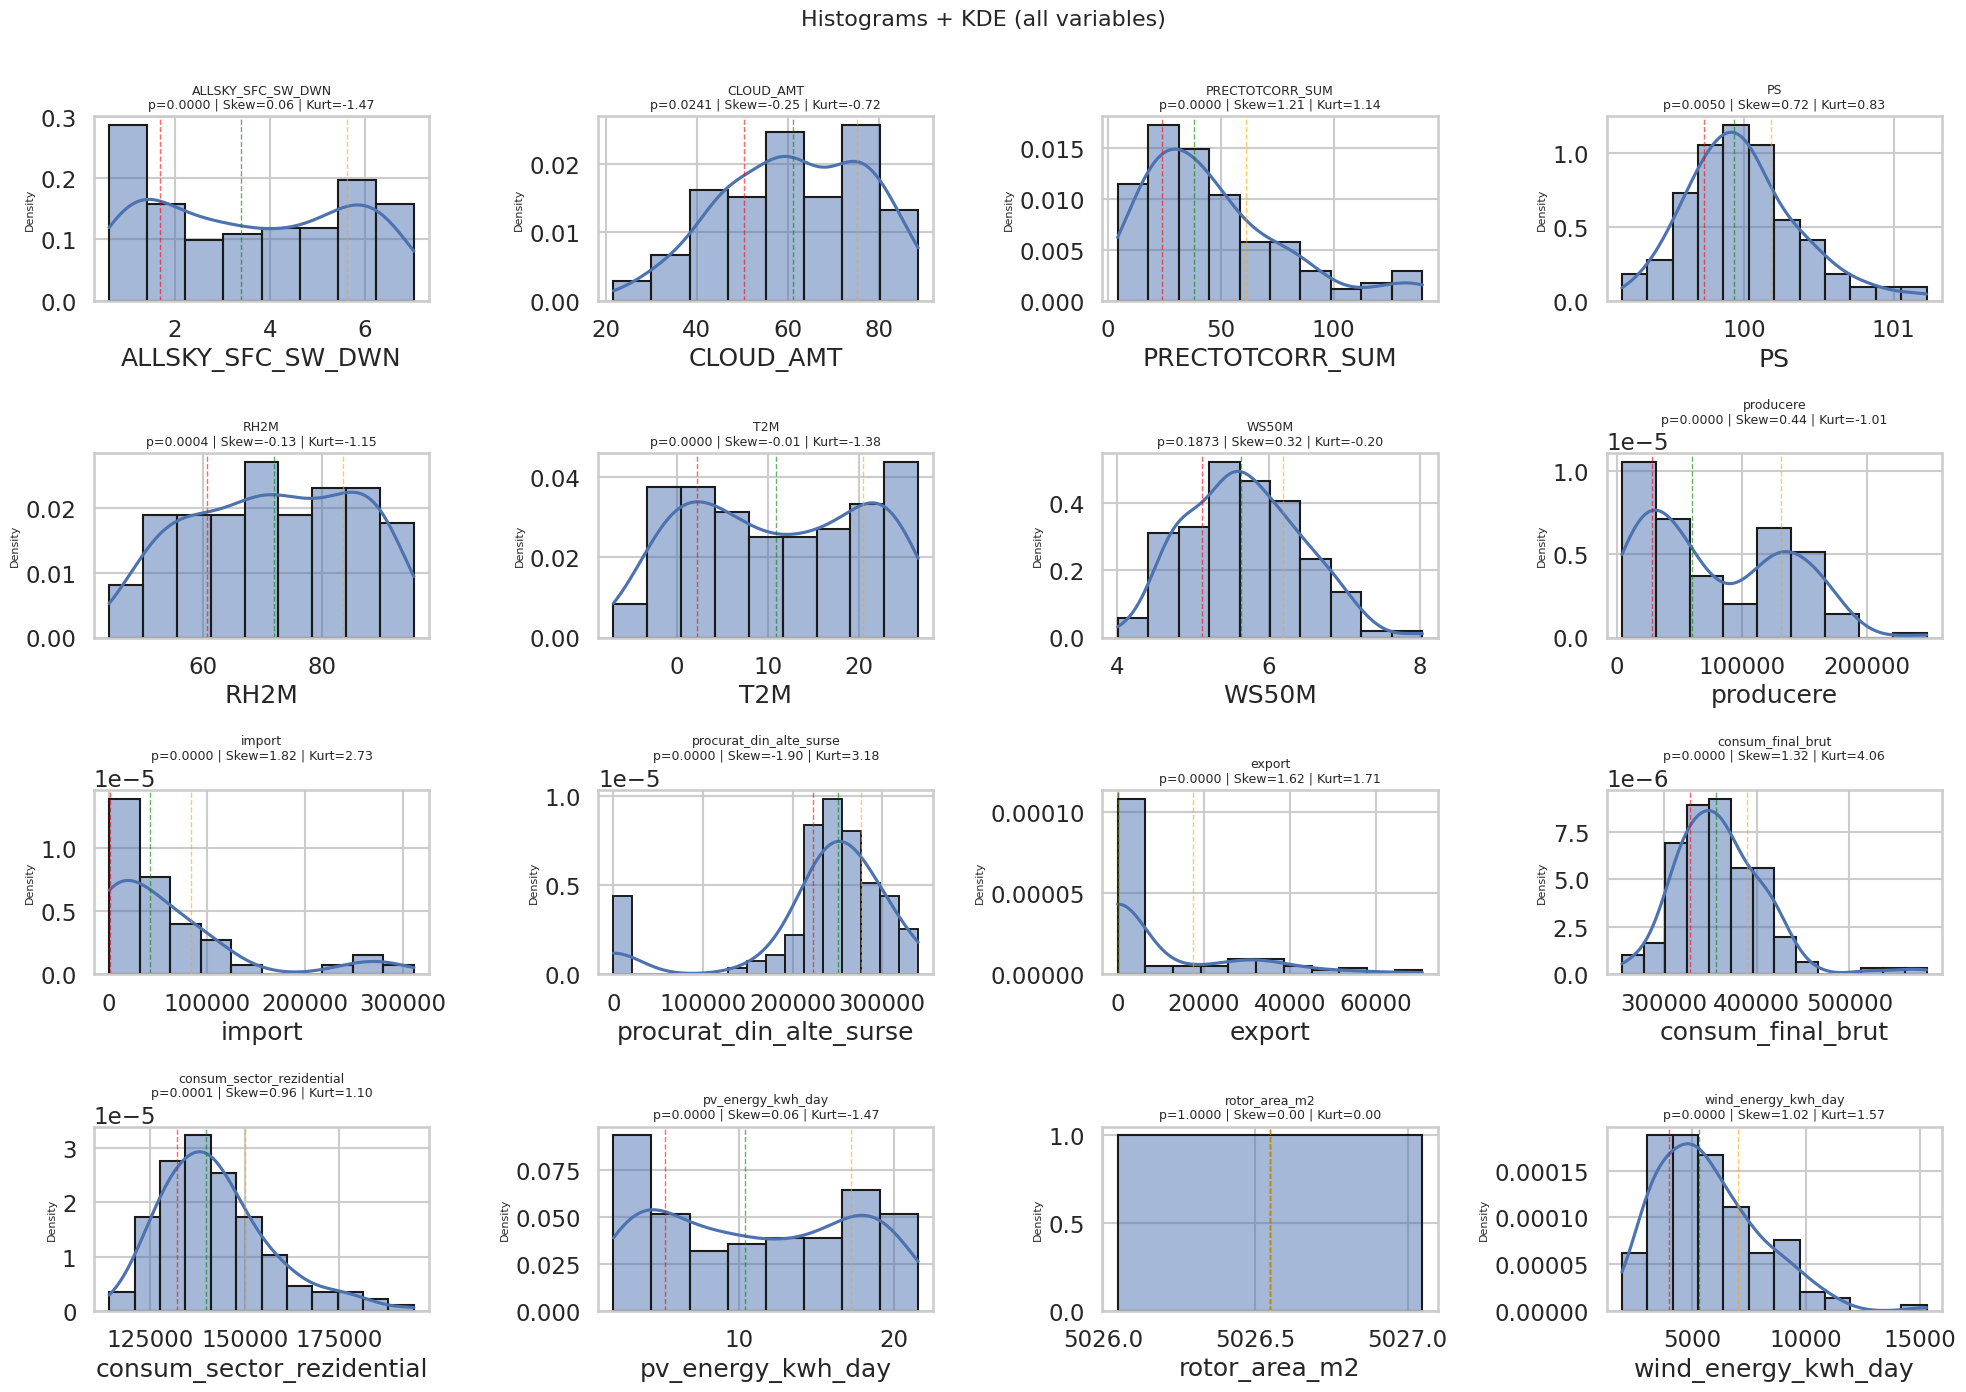

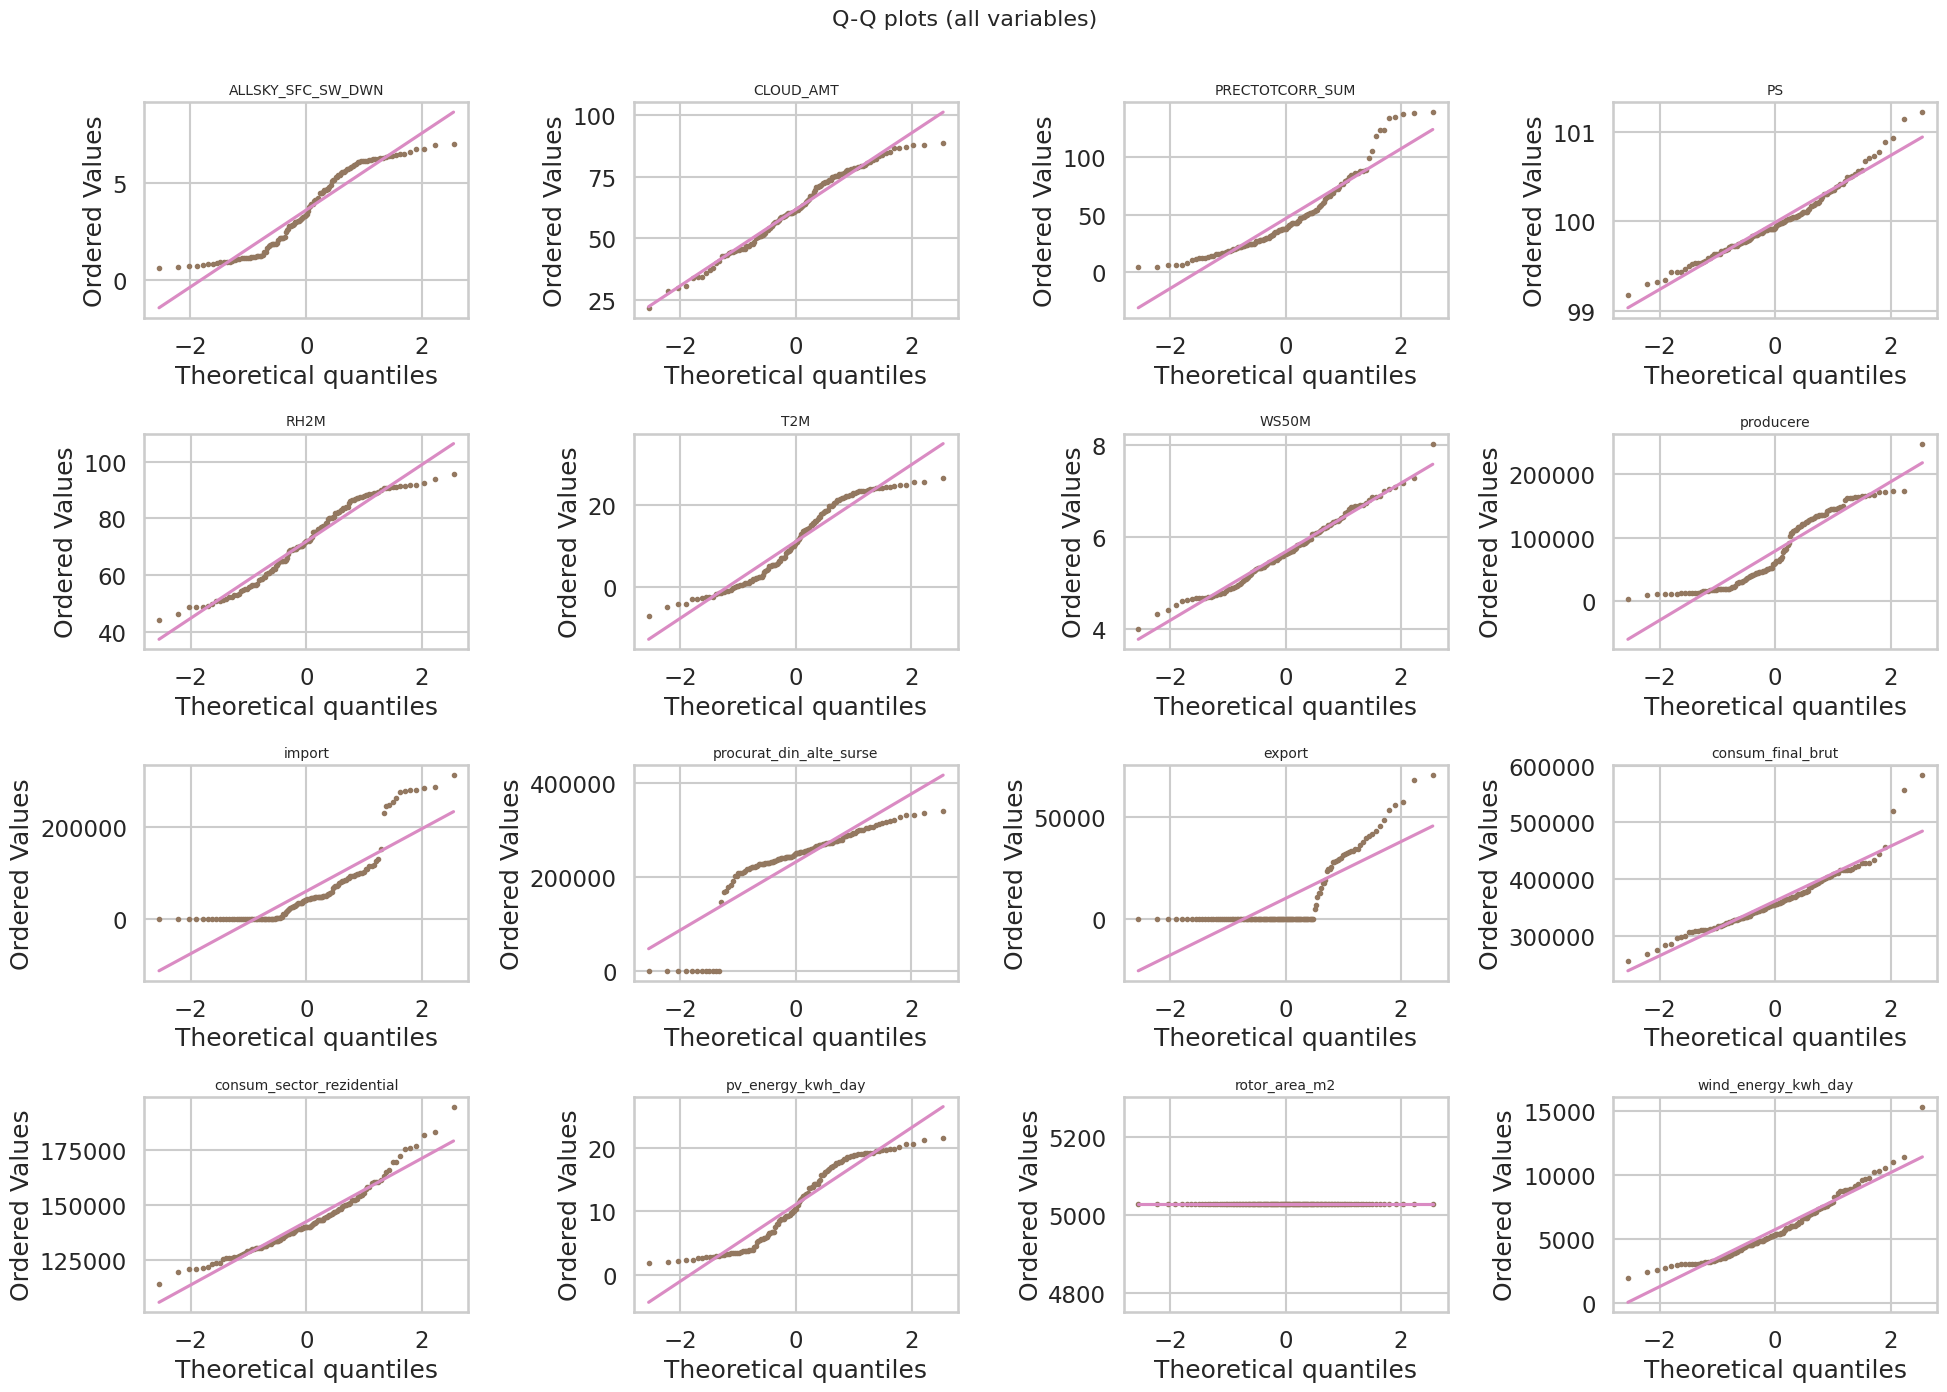

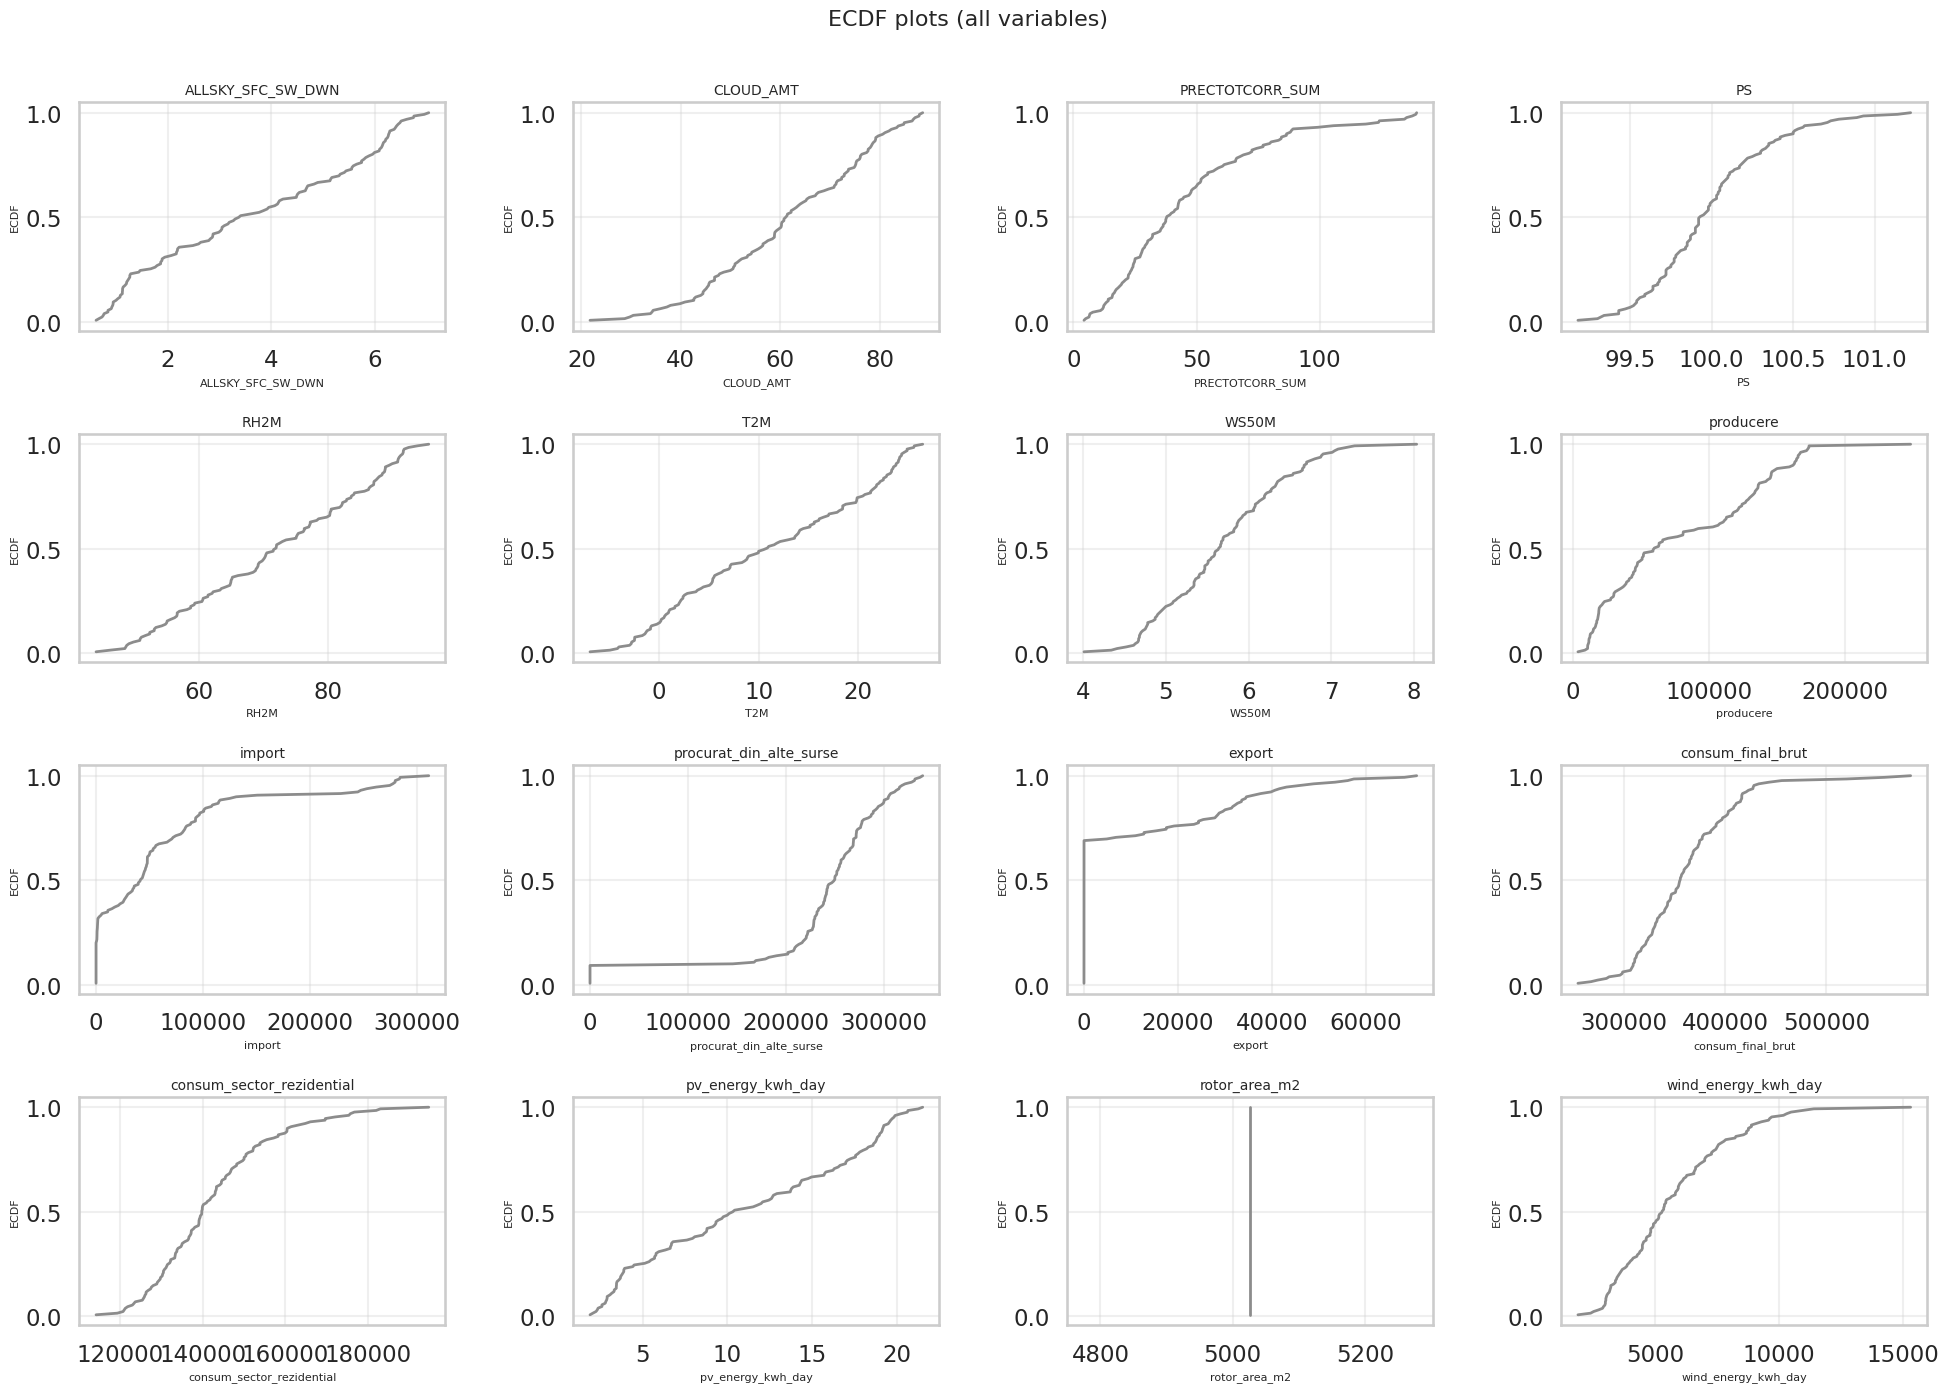

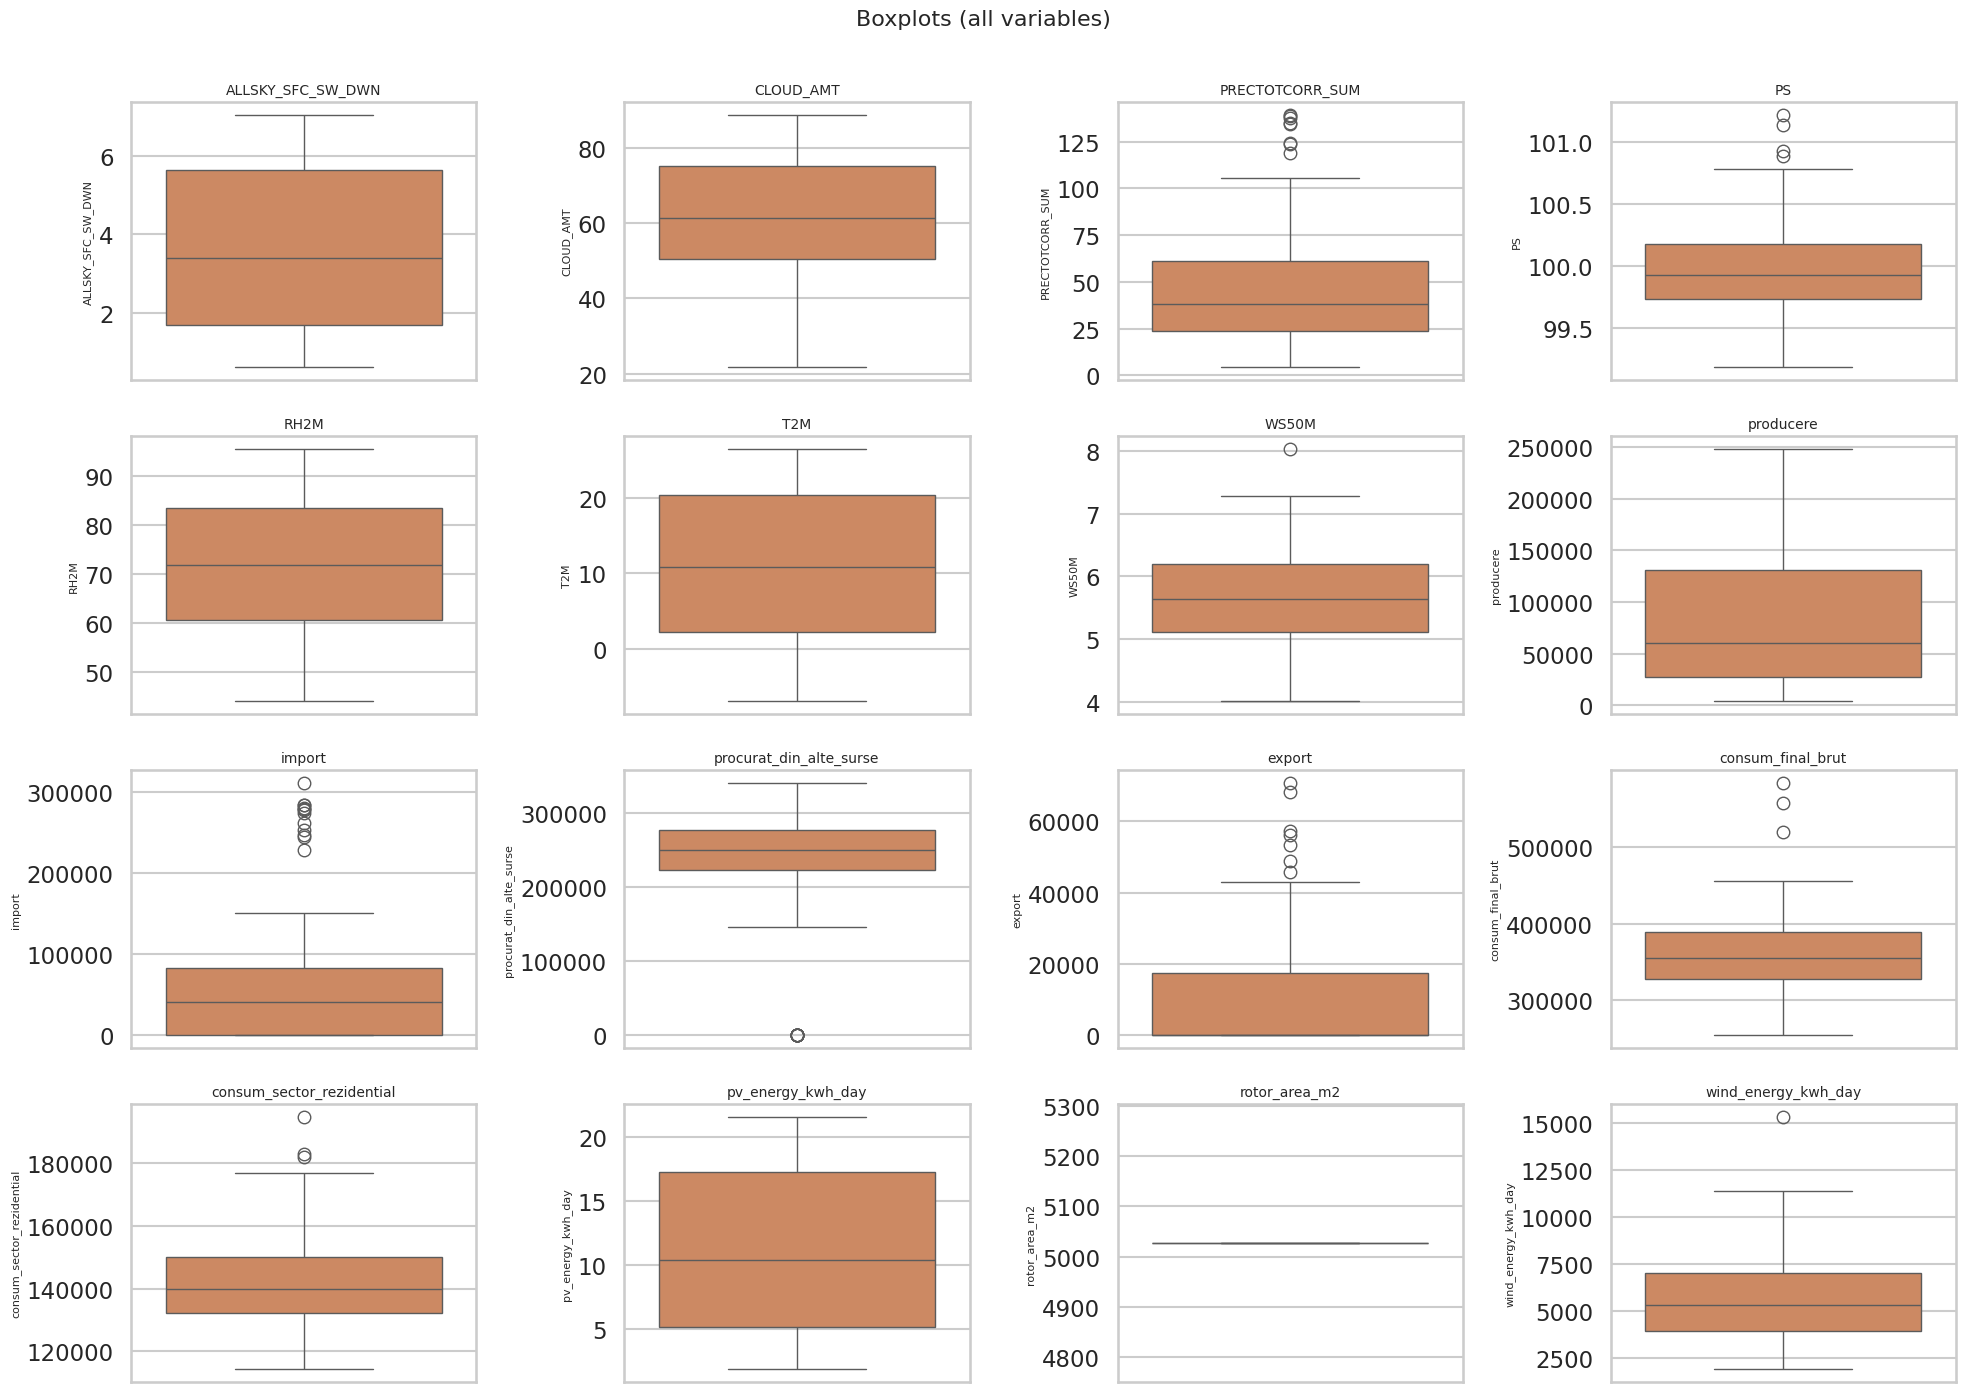

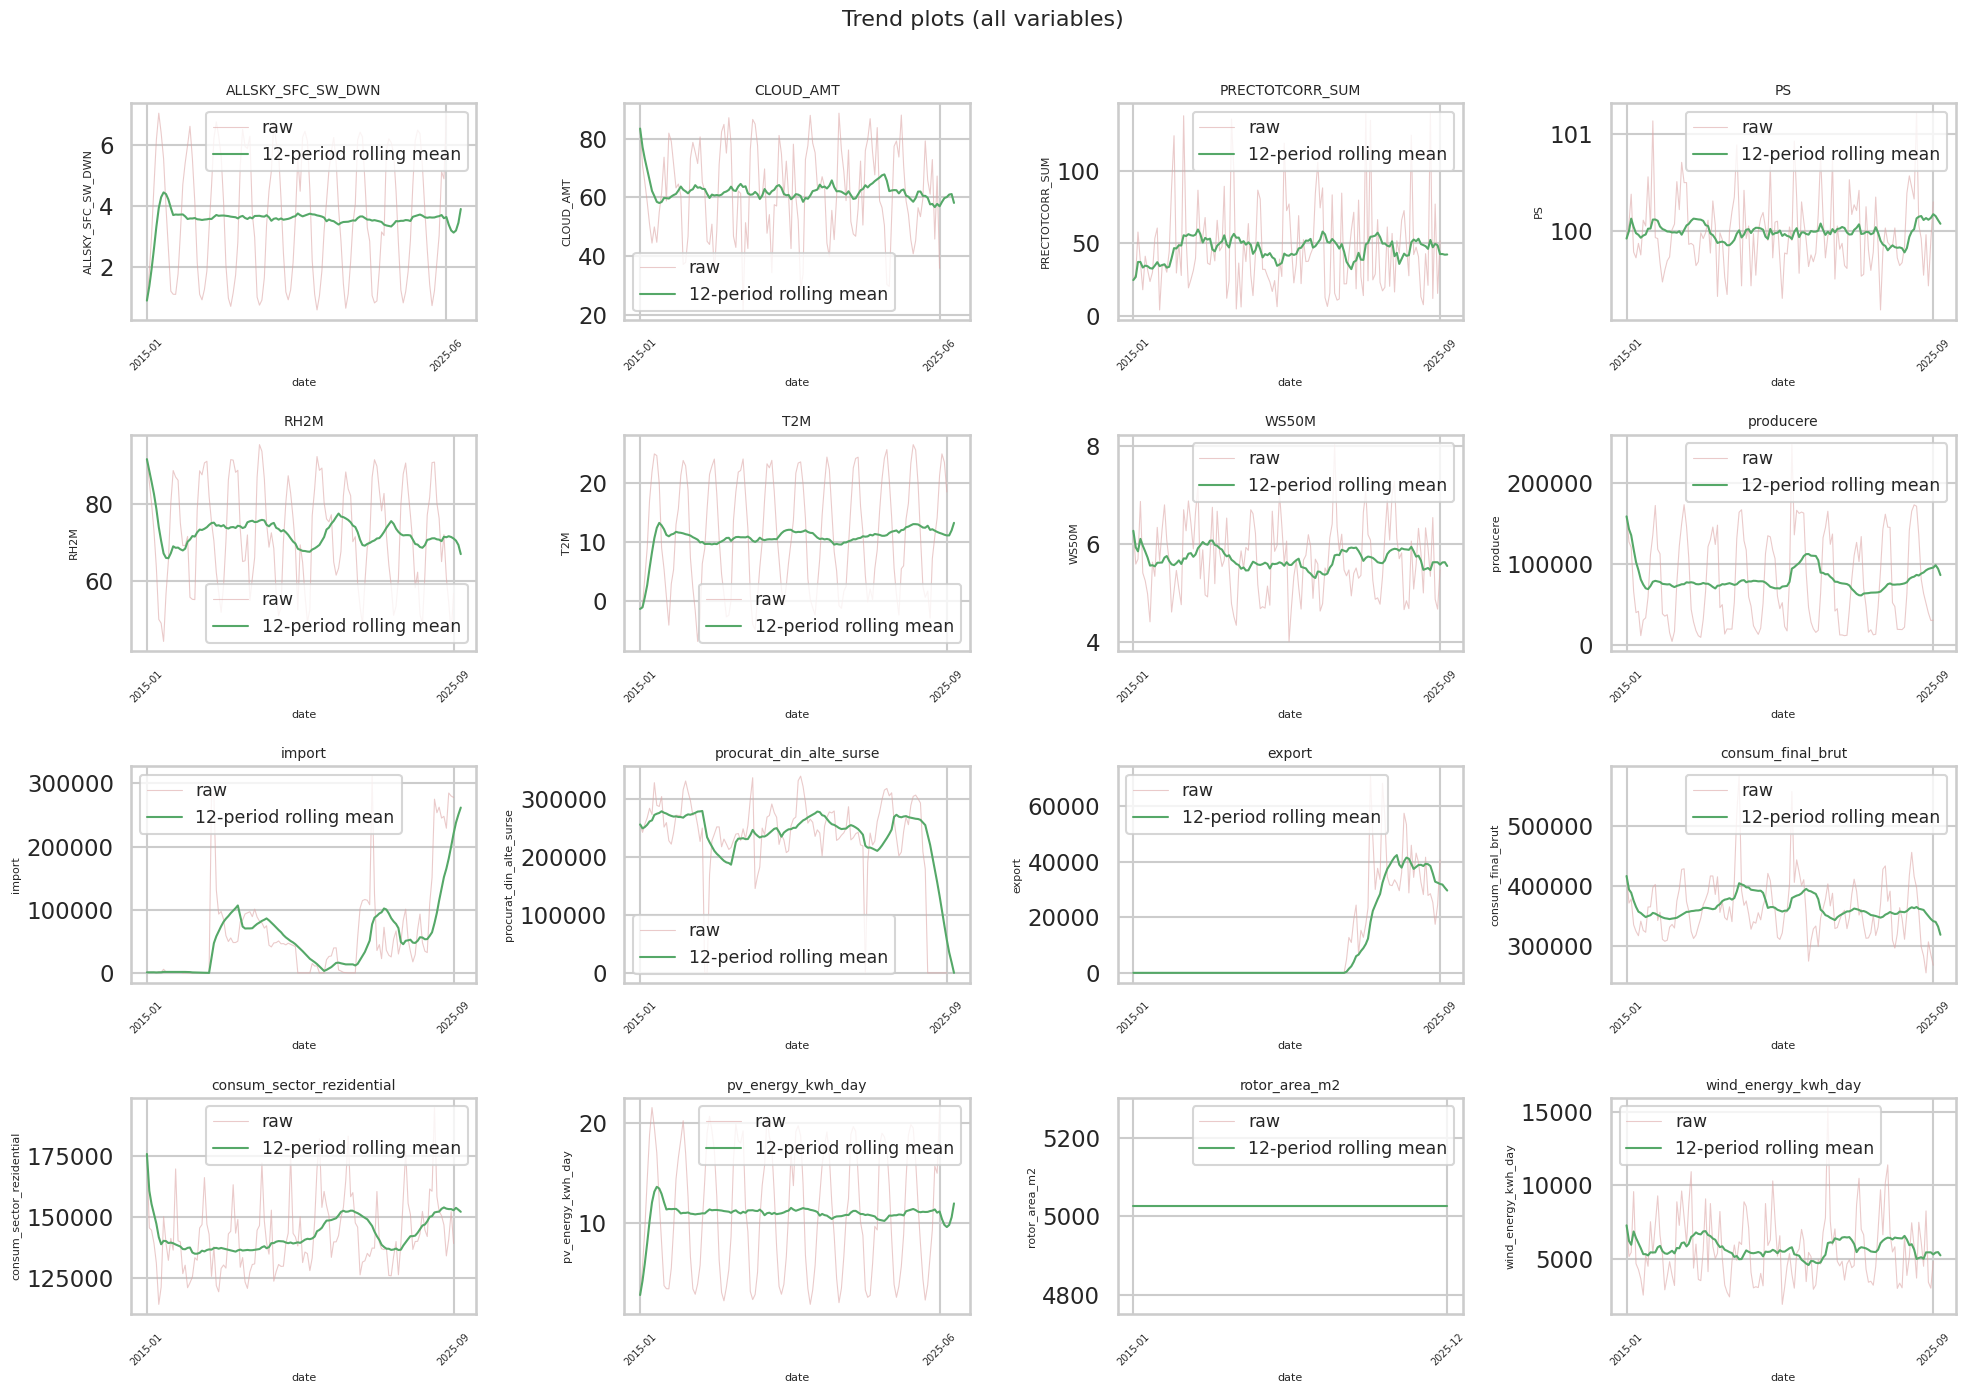

/home/aureliaaa/Downloads/PAAD/.venv/lib64/python3.13/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


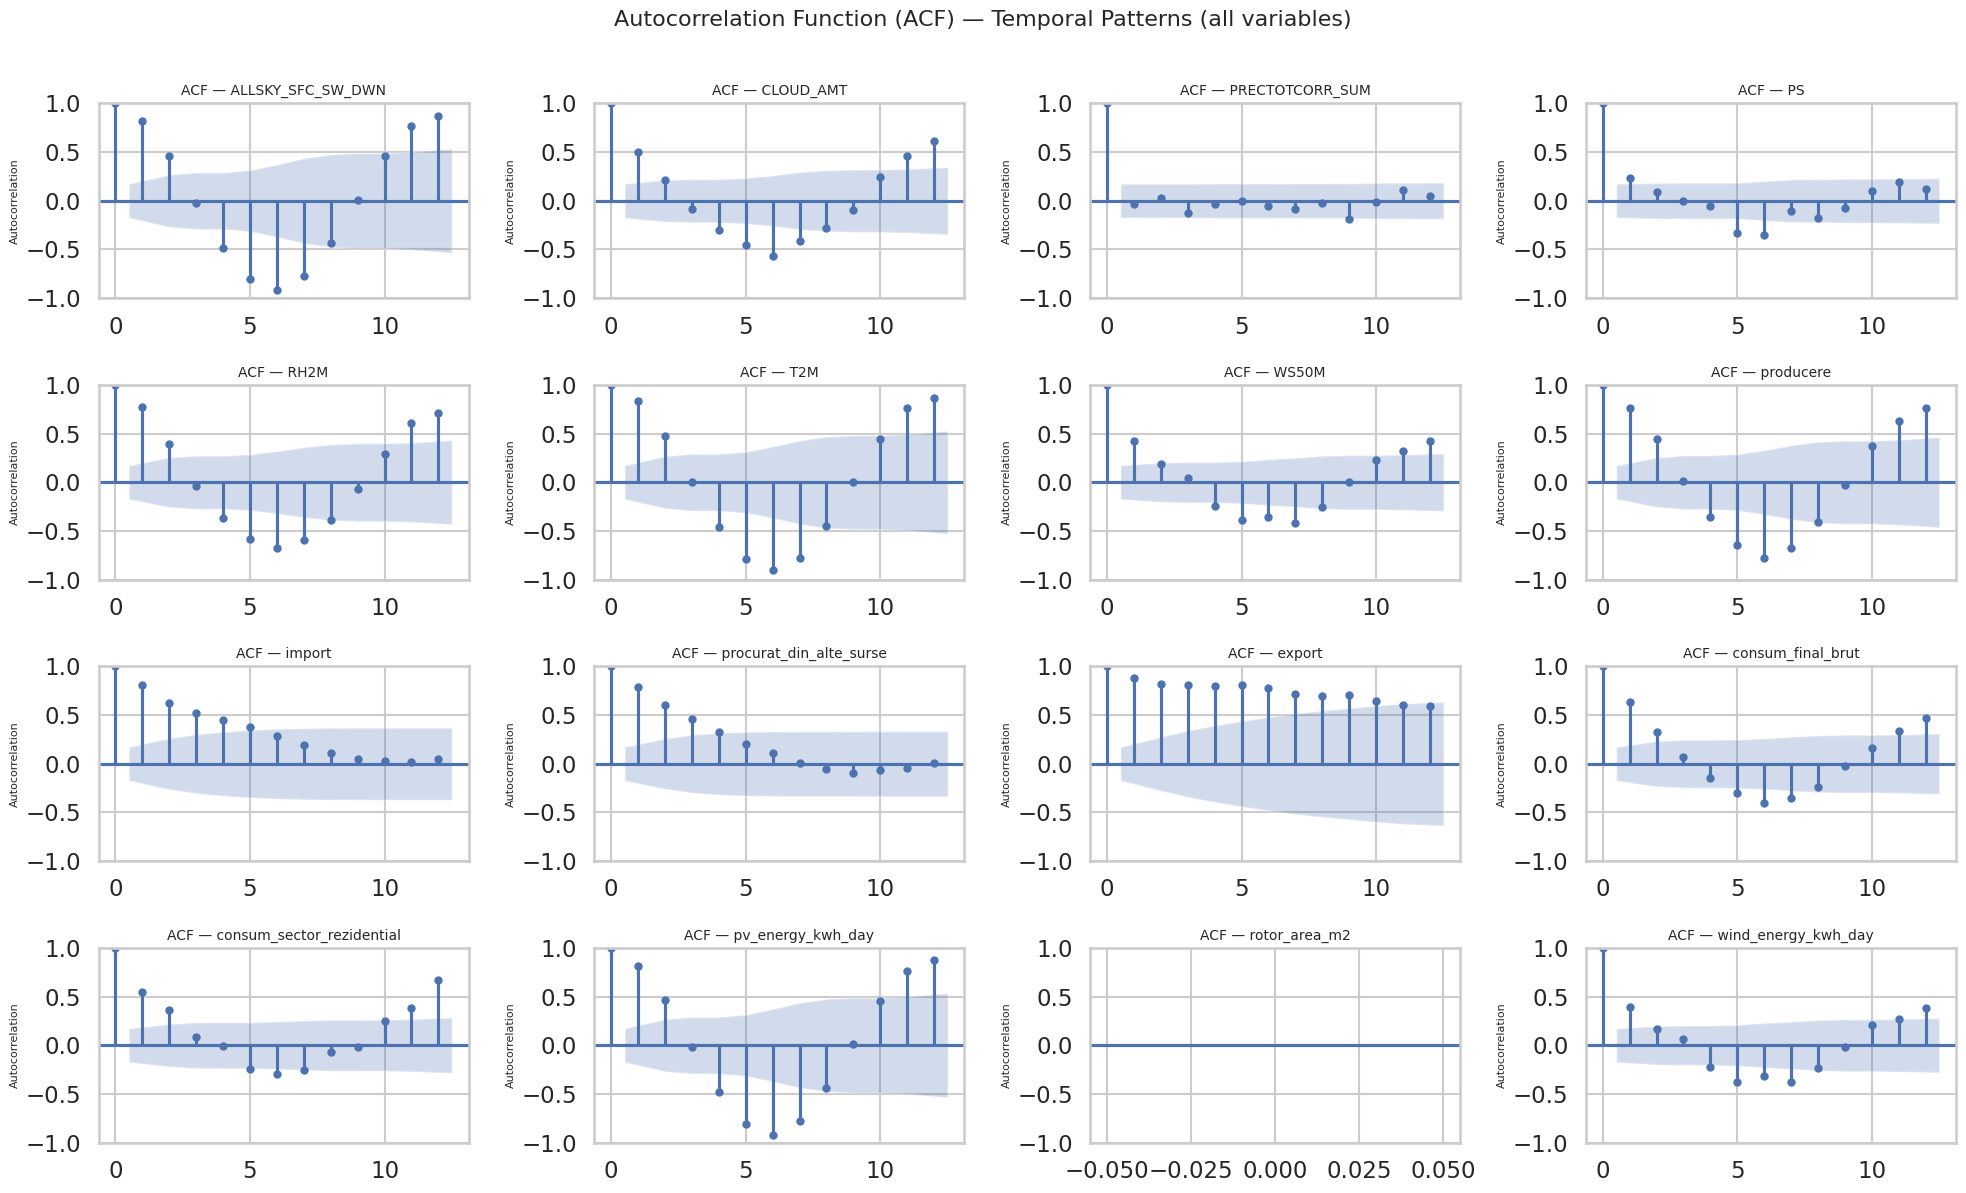

Mean         Std          Min           Q1  \
ALLSKY_SFC_SW_DWN               3.6243      2.0414       0.6134       1.6913   
CLOUD_AMT                      61.7328     15.5007      21.7300      50.5250   
PRECTOTCORR_SUM                46.6430     31.7417       4.3100      23.8200   
PS                             99.9881      0.3751      99.1800      99.7300   
RH2M                           71.8531     13.6198      44.1100      60.6000   
T2M                            11.1198      9.5173      -6.9400       2.2100   
WS50M                           5.6822      0.7408       4.0100       5.1200   
producere                   78745.5411  56550.3432    3848.6000   27714.7000   
import                      60441.6178  77068.8476       0.0000     961.3000   
procurat_din_alte_surse    232024.9814  82913.6099       0.0000  222689.4000   
export                      10014.1202  17194.4201       0.0000       7.1000   
consum_final_brut          361198.0233  49889.0469  254467.4000  328344.7000   
consum_sector_rezidential  142374.3512  14617.5587  114167.0000  132023.0000   
pv_energy_kwh_day              11.0903      6.2468       1.8770       5.1755   
rotor_area_m2                5026.5482      0.0000    5026.5482    5026.5482   
wind_energy_kwh_day          5700.4880   2271.6752    1905.8131    3966.9531   

                                Median           Q3          Max  Skewness  \
ALLSKY_SFC_SW_DWN               3.3886       5.6326       7.0416    0.0552   
CLOUD_AMT                      61.2250      75.1775      88.6700   -0.2467   
PRECTOTCORR_SUM                37.9700      61.2300     139.3600    1.2104   
PS                             99.9300     100.1800     101.2200    0.7220   
RH2M                           71.9400      83.5700      95.5300   -0.1325   
T2M                            10.8700      20.4300      26.4600   -0.0106   
WS50M                           5.6400       6.1900       8.0300    0.3214   
producere                   59937.9000  131214.9000  247967.6000    0.4373   
import                      41705.1000   83688.6000  311396.0000    1.8188   
procurat_din_alte_surse    250198.2000  276439.0000  340034.5000   -1.9012   
export                          8.1000   17539.2000   70770.8000    1.6159   
consum_final_brut          355599.1000  389111.7000  583245.2000    1.3185   
consum_sector_rezidential  139783.1000  150033.0000  194767.0000    0.9561   
pv_energy_kwh_day              10.3693      17.2359      21.5473    0.0552   
rotor_area_m2                5026.5482    5026.5482    5026.5482    0.0000   
wind_energy_kwh_day          5302.5466    7010.0179   15303.6075    1.0181   

                           Kurtosis  CV (%)  
ALLSKY_SFC_SW_DWN           -1.4705   56.33  
CLOUD_AMT                   -0.7159   25.11  
PRECTOTCORR_SUM              1.1398   68.05  
PS                           0.8279    0.38  
RH2M                        -1.1500   18.96  
T2M                         -1.3841   85.59  
WS50M                       -0.2037   13.04  
producere                   -1.0051   71.81  
import                       2.7281  127.51  
procurat_din_alte_surse      3.1809   35.73  
export                       1.7137  171.70  
consum_final_brut            4.0643   13.81  
consum_sector_rezidential    1.0993   10.27  
pv_energy_kwh_day           -1.4705   56.33  
rotor_area_m2                0.0000    0.00  
wind_energy_kwh_day          1.5731   39.85

In [9]:
# All distribution plots organized by plot type (not by variable)
sns.set(style="whitegrid", context="talk")
numeric_cols = [c for c in df.select_dtypes(include="number").columns 
                if c not in ("year", "month", "variatia_stocurilor")]

n_vars = len(numeric_cols)
cols = 4
rows = math.ceil(n_vars / cols)


# 1) Grid of Histograms + KDE with normality test
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    stat, p_value = stats.shapiro(series)
    skewness = series.skew()
    kurtosis = series.kurtosis()
    normality_text = f"p={p_value:.4f} | Skew={skewness:.2f} | Kurt={kurtosis:.2f}"
    
    sns.histplot(series, kde=True, ax=ax, color="C0", edgecolor="k", stat="density")
    ax.set_title(f"{col}\n{normality_text}", fontsize=9)
    ax.set_ylabel("Density", fontsize=8)
    
    q1, q2, q3 = series.quantile([0.25, 0.5, 0.75])
    ax.axvline(q1, color="red", linestyle="--", linewidth=1, alpha=0.6)
    ax.axvline(q2, color="green", linestyle="--", linewidth=1, alpha=0.6)
    ax.axvline(q3, color="orange", linestyle="--", linewidth=1, alpha=0.6)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Histograms + KDE (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 2) Grid of Violin plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sns.violinplot(y=series, ax=ax, color="C4")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_ylabel(col, fontsize=8)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Violin plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 3) Grid of Q-Q plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    stats.probplot(series, dist="norm", plot=ax)
    ax.set_title(f"{col}", fontsize=10)
    ax.get_lines()[0].set_color("C5")
    ax.get_lines()[0].set_marker("o")
    ax.get_lines()[0].set_markersize(3)
    ax.get_lines()[1].set_color("C6")

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Q-Q plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 4) Grid of ECDF plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sorted_series = np.sort(series)
    ecdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    ax.plot(sorted_series, ecdf, linewidth=2, color="C7")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_xlabel(col, fontsize=8)
    ax.set_ylabel("ECDF", fontsize=8)
    ax.grid(True, alpha=0.3)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("ECDF plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 5) Grid of Boxplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    if series.empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    sns.boxplot(y=series, ax=ax, color="C1")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_ylabel(col, fontsize=8)

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Boxplots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 6) Grid of Trend plots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3.5))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    s_full = df[col]
    ax = axes[i]
    if s_full.dropna().empty:
        ax.text(0.5, 0.5, "no data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    ax.plot(s_full.index, s_full.values, color="#dda8a8", linewidth=0.8, alpha=0.6, label="raw")
    rolling = s_full.rolling(window=12, min_periods=1, center=False).mean()
    ax.plot(rolling.index, rolling.values, linestyle="-", color="C2", linewidth=1.5, label="12-period rolling mean")
    ax.set_title(f"{col}", fontsize=10)
    ax.set_xlabel("date", fontsize=8)
    ax.set_ylabel(col, fontsize=8)
    date_range = s_full.index[~s_full.isna()]
    if len(date_range) > 1:
        ax.set_xticks([date_range[0], date_range[-1]])
        ax.set_xticklabels([date_range[0].strftime('%Y-%m'), date_range[-1].strftime('%Y-%m')], rotation=45, fontsize=7)
    ax.legend(fontsize="x-small", loc="best")

for j in range(n_vars, len(axes)):
    axes[j].axis("off")
fig.suptitle("Trend plots (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# 7) Autocorrelation Analysis (ACF)
from statsmodels.graphics.tsaplots import plot_acf

n_lags = 12
n_plots = len(numeric_cols)
cols = 4
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    series = df[col].dropna()
    ax = axes[i]
    
    if len(series) < 3:
        ax.text(0.5, 0.5, "insufficient data", ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    plot_acf(series, lags=min(n_lags, len(series)//2), ax=ax, alpha=0.05)
    ax.set_title(f"ACF — {col}", fontsize=10)
    ax.set_ylabel("Autocorrelation", fontsize=8)

for j in range(n_plots, len(axes)):
    axes[j].axis("off")

fig.suptitle("Autocorrelation Function (ACF) — Temporal Patterns (all variables)", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()
plt.close(fig)

# Summary statistics table
summary_stats = pd.DataFrame({
    "Mean": df[numeric_cols].mean(),
    "Std": df[numeric_cols].std(),
    "Min": df[numeric_cols].min(),
    "Q1": df[numeric_cols].quantile(0.25),
    "Median": df[numeric_cols].quantile(0.5),
    "Q3": df[numeric_cols].quantile(0.75),
    "Max": df[numeric_cols].max(),
    "Skewness": df[numeric_cols].skew(),
    "Kurtosis": df[numeric_cols].kurtosis(),
    "CV (%)": (df[numeric_cols].std() / df[numeric_cols].mean() * 100).round(2)
})
display(summary_stats.round(4))

În această analiză univariată a datelor energetice lunare, am urmat pașii de mai jos:

**1. Prelucrarea datelor**
- Am încărcat setul de date `dataset_lunar_energie.csv`, am convertit coloana de dată și am setat-o ca index.
- Am transformat toate coloanele relevante la tip numeric, gestionând valorile lipsă.

**2. Identificarea variabilelor numerice**
- Am selectat variabilele numerice relevante, excluzând coloane neinformative (ex: `year`, `month`, etc.).

**3. Statistici descriptive și meta-informații**
- Am calculat statistici descriptive pentru fiecare variabilă numerică: medie, deviație standard, minim, maxim, quartile, skewness, kurtosis, coeficient de variație.
- Am analizat tipul de date, numărul de valori lipsă și numărul de valori unice.

**4. Detectarea outlierilor**
- Am folosit două metode: regula IQR și scorul Z pentru a identifica valorile extreme din fiecare variabilă numerică.

**5. Vizualizări univariate**
Pentru fiecare variabilă numerică am generat:
- Histograme cu KDE și testul de normalitate Shapiro-Wilk, plus valori de skewness și kurtosis.
- Violin plot pentru distribuție.
- Q-Q plot pentru verificarea normalității.
- ECDF plot pentru distribuția cumulativă.
- Boxplot pentru identificarea outlierilor.
- Grafic de trend cu media mobilă pe 12 perioade pentru a observa evoluția temporală.

**6. Vizualizări agregate**
- Am organizat graficele pe tipuri (histograme, violin, Q-Q, ECDF, boxplot, trend) pentru toate variabilele simultan, facilitând comparația între ele.
- Am realizat analiza autocorelației (ACF) pentru a identifica tipare temporale.

**Rezultate și concluzii**
- Am obținut o imagine detaliată asupra distribuției fiecărei variabile, gradului de normalitate, prezenței outlierilor și evoluției în timp.
- Majoritatea variabilelor prezintă abateri de la normalitate (skewness/kurtosis semnificative, p < 0.05 la Shapiro-Wilk).
- Outlierii au fost identificați și cuantificați.
- Analiza autocorelației a evidențiat posibile tipare sezoniere sau dependențe temporale.
- Metodele folosite au fost: statistici descriptive, testul Shapiro-Wilk, regula IQR, scorul Z, vizualizări statistice (histogramă, KDE, violin, Q-Q, ECDF, boxplot, trend), autocorelație (ACF).

**Modelul analitic**
- Analiza a fost una exploratorie, bazată pe metode statistice descriptive și vizualizări, fără aplicarea unor modele predictive sau de regresie.

**Concluzie**
- Datele prezintă variabilitate semnificativă, cu distribuții adesea asimetrice și prezența outlierilor.
- Evoluția temporală și autocorelația indică existența unor tipare sezoniere.
- Analiza univariată oferă o bază solidă pentru investigații ulterioare (bivariată/multivariată) și pentru selecția variabilelor relevante în modele predictive.